In [1]:
import cv2
import numpy as np
import os

In [2]:
color_list = [(255,0,0),
             (255,255,0),
             (255,0,255),
             (255,255,255),
             (0,0,255),
             (0,255,0),
             (128,0,0),
             (128,128,0),
             (128,0,128),
             (128,128,128),
             (0,0,128),
             (0,128,0),
             (64,0,0),
             (64,64,0),
             (64,0,64),
             (64,64,64),
             (0,0,64),
             (0,64,0),
             (32,0,0),
             (32,32,0),
             (32,0,32),
             (32,32,32),
             (0,0,32),
             (0,32,0)
             ]

In [103]:
classes_all = np.array([
                         'u-turn', 'keep-right', 'keep-left', 'pass-either-side',
                         'compulsory-motor-cycles-track', 'stop', 'no-left-turn', 'no-right-turn', 'no-u-turn',
                         'no-entry', 'weight-limit-sign-5T', 'weight-limit-sign-30T', 'height-limit-sign-2.-m',
                         'height-limit-sign-3.-m', 'height-limit-sign-4.-m', 'height-limit-sign-5.-m', 'height-limit-sign-6.-m',
                         'speed-limit-20', 'speed-limit-30', 'speed-limit-40', 'speed-limit-50', 'speed-limit-60', 'speed-limit-70',
                         'speed-limit-80', 'speed-limit-90','speed-limit-110', 'no-entry-for-vehicles-ex-5T-truntks-etc',
                         'heavy-vehicles-no-driving-on-right-lane', 'no-parking', 'no-stopping', 'give-way', 'wide-limit-3.-m',
                         'no-overtaking', 'road-work', 'camera-operation-zone', 'crosswind-area', 'caution-hump',
                         'hump-ahead', 'towing-zone', 'left-bend', 'slippery-road', 'pedestrain-crossing-opt1', 'pedestrain-crossing-opt2',
                         'school-childern-crossing-opt1', 'school-childern-crossing-opt2', 'caution', 'narrow-roads-on-the-left',
                         'traffic-lights-ahead', 'obstacles', 'staggered-junctions', 'crossroads-T-junction', 'crossroads-to-the-right',
                         'crossroads-to-the-left', 'exit-to-the-left', 'crossroads', 'minor-road-on-right', 'minor-road-on-left',
                         'minor-road-on-left-opt2', 'cattle-crossing', 'roundabout-ahead', 'narrow-bridge','split-way', 'two-way-road',
                         'divided-road-ending', 'curve-on-the-left', 'crossroads-Y-junction'])

In [104]:
classes_all[62]

'two-way-road'

In [242]:
kept = [7,8,16,23,27,37,49,57,58,62]
kept[:] = [x - 1 for x in kept]
classes = classes_all[kept]
for c in classes:
    print("\'{}\', ".format(c))

'no-left-turn', 
'no-right-turn', 
'height-limit-sign-5.-m', 
'speed-limit-70', 
'no-entry-for-vehicles-ex-5T-truntks-etc', 
'caution-hump', 
'obstacles', 
'minor-road-on-left', 
'minor-road-on-left-opt2', 
'split-way', 


In [114]:
np.where(classes == 'no-right-turn')[0][0]

1

In [233]:
experiment = 4

anno_file_path = 'data/MTSD/Annotations/gt_reduced.txt'
num_cls = 10

im_path = './data/MTSD/Images/'
#im_path = './testing_images'

label_path = './data/test{}/labels/'.format(experiment)
aug_path = './data/test{}/aug/'.format(experiment)
aug_gt_path = './data/test{}/aug_gt/'.format(experiment)
aug_labels_path = './data/test{}/aug_labels/'.format(experiment)
aug_output_path = './data/test{}/aug/output/'.format(experiment)
aug2_path = './data/test{}/aug2/'.format(experiment)
aug2_gt_path = './data/test{}/aug2_gt/'.format(experiment)
aug2_labels_path = './data/test{}/aug2_labels/'.format(experiment)
aug2_output_path = './data/test{}/aug2/output/'.format(experiment)

# Splitting the dataset into Train 70% and Test 30%

(1) Read the GT into a dictionary with file name as key

(2) Calculate the frequancy of each class

(3) Sort with key of minimum of minimum frequancy in the dictionary value

(4) Calculate the 30% frequancy for each class and round the value

(5) If at least one of the values frequancy of 30% will be less than 0 after subtract from 1 then add key to train_set otherwise add to test_set

In [234]:
# (1) Read the GT into a dictionary with file name as key
gt_in_f = open(anno_file_path, 'r')

lines = gt_in_f.readlines()
dic = {}
tmp = []

for line in lines:
    spl = line.split(';')
    tmp.append(int(spl[5]))
    if dic.has_key(spl[0]):
        dic[spl[0]].append(line)
    else:
        dic[spl[0]] =[line]
        
print(len(dic))

print(dic.items()[0][1])
print(dic['88.jpg'])

print(dic.keys()[0])

# lambda example
#a = 1
#b = 2
#dd = lambda (k,v): (v,k)
#x = dd((a,b))
#print(x)

# (2) Calculate the frequancy of each class
_, counts = np.unique(np.array(tmp), return_counts=True)
frq = np.array(counts)

print(frq)

# (3) Sort with key of minimum of minimum frequancy in the dictionary value
def min_frq(vv, frq):
    min_f = frq[int(vv[0].split(';')[5].strip())]
    for v in vv:
        spl = v.split(';')
        cfrq = frq[int(spl[5].strip())]
        if cfrq < min_f:
            min_f = cfrq
    return min_f

# (4) Calculate the 30% frequancy for each class and round the value
frq_30 = np.round(frq*30/100.0)
#frq_70 = np.round(frq*70/100.0)
print(frq_30)
#print(frq_70)


train_keys = []
test_keys = []

for key, value in sorted(dic.iteritems(), key=lambda (k,v): min_frq(v, frq)): #len(v)):
    flag_test = True
    #print("%s:\t\t\t" % (key), end='')
    for val in value:
        #print (val.replace('\n','\t')," ",end='')
        cls = int(val.split(';')[5].strip())
        if (frq_30[cls] - 1) == -1:
            flag_test = False
            break
    # (5) If at least one of the values frequancy of 30% will \
    #     be less than 0 after subtract from 1 then add key to train_set otherwise add to test_set
    if flag_test:
        ## Test
        for val in value:
            cls = int(val.split(';')[5].strip())
            frq_30[cls] -= 1
        test_keys.append(key)
    else:
        train_keys.append(key)
    #print("")
    
    
        

485
['P1840472.JPG;3472;1169;3707;1400;0\n']
['88.jpg;479;592;505;613;9\n', '88.jpg;517;572;535;587;9\n', '88.jpg;518;552;537;569;6\n']
P1840472.JPG
[ 11   6 144   4  12  72 235  87   4 264]
[ 3.  2. 43.  1.  4. 22. 70. 26.  1. 79.]


In [235]:
print("Train_keys = ", len(train_keys),", Test_keys = ", len(test_keys), ", Total number of images = ", (len(train_keys)+len(test_keys)))
print((len(train_keys)+len(test_keys)) == len(dic))

Train_keys =  343 , Test_keys =  142 , Total number of images =  485
True


In [236]:
tmp2 = []
for tests in test_keys:
    for line in dic[tests]:
        spl = line.split(';')
        tmp2.append(int(spl[5]))
        
_, counts2 = np.unique(np.array(tmp2), return_counts=True)
frq_of_tests = np.array(counts2)
print("Freq of Test set",frq_of_tests)

tmp2 = []
for trains in train_keys:
    for line in dic[trains]:
        spl = line.split(';')
        tmp2.append(int(spl[5]))
        
_, counts2 = np.unique(np.array(tmp2), return_counts=True)
frq_of_trains = np.array(counts2)
print("Freq of Train set",frq_of_trains)

print("Sum = ", frq_of_trains + frq_of_tests, ' = ', frq)

Freq of Test set [ 3  2 43  1  4 22 70 26  1 79]
Freq of Train set [  8   4 101   3   8  50 165  61   3 185]
Sum =  [ 11   6 144   4  12  72 235  87   4 264]  =  [ 11   6 144   4  12  72 235  87   4 264]


In [240]:
file_p = open(anno_file_path.replace('.txt', '.train.txt'),'wt')
#anno_file_path.replace('.txt', '.train.txt')

for trains in train_keys:
    for line in dic[trains]:
        file_p.write(line)
file_p.close()

file_p = open(anno_file_path.replace('.txt', '.test.txt'), 'wt')
for tests in test_keys:
    for line in dic[tests]:
        file_p.write(line)
file_p.close()

## 1) Calculate the freq of each class and store all the freq < 50 in keep varaibale array

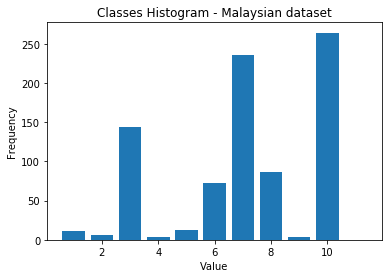

len 10
11
6
144
4
12
72
235
87
4
264
freq->
 [ 11   6 144   4  12  72 235  87   4 264]
Mean: 83.90
 Var: 8835.09
 Max: 264.00
 Min: 4.00
 Sum: 839.00
 STD: 94.00
 CV: 1.12

Total number of objects: 839


In [117]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

#file_p = 'data/MTSD/Annotations/gt_reduced.txt'


file_p = open(anno_file_path,'rt')


tmp = []
for line in file_p:
    tmp.append( int(line.split(';')[5].replace('\r\n',''))+1)
#plt.hist(x, normed=True, bins=30)
# hist, bins = np.histogram(tmp, bins=66)
# width = 0.7 * (bins[1] - bins[0])
# center = (bins[:-1] + bins[1:]) / 2
# plt.bar(center, hist, align='center', width=width)
# plt.legend()
# plt.show()

plt.hist(tmp,histtype='bar', rwidth=0.8,bins=range(1,num_cls+3,1), align='left')
###plt.hist(tmp,histtype='bar', rwidth=0.8,bins=range(1,50,1), align='left')
plt.title("Classes Histogram - Malaysian dataset")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.show()

#print tmp
file.close()
a = np.array(tmp)
unique, counts = np.unique(a, return_counts=True)

frq = np.array(counts)
# print counts
keep = np.where(frq < 50)
# print keep
# print classes[keep]
# print a.mean(), a.var(), a.max(), a.min(), a.sum(), a.std()
# print frq.mean(), frq.var(), frq.max(), frq.min(), frq.sum(), frq.std()
# print len(tmp)

print('len',len(counts))
for ck in counts:
    print(ck)

print('freq->\n',counts)
#print keep
#print classes[keep]
#print a.mean(), a.var(), a.max(), a.min(), a.sum(), a.std()
print('Mean: {:.2f}\n'.format(frq.mean()),\
    'Var: {:.2f}\n'.format(frq.var()),\
    'Max: {:.2f}\n'.format(frq.max()),\
    'Min: {:.2f}\n'.format(frq.min()),\
    'Sum: {:.2f}\n'.format(frq.sum()),\
    'STD: {:.2f}\n'.format(frq.std()),\
    'CV: {:.2f}\n'.format(frq.std()/frq.mean()) )
print('Total number of objects:',len(tmp))

# Calculating the blur factor NEW

blur factor =  575.0184930109173 1.053147423096918


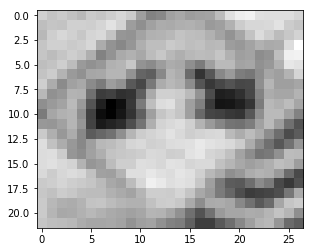

blur factor =  654.907158933518 2.4255820701241406


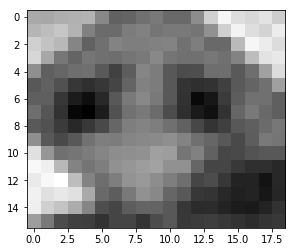

blur factor =  613.1988888888889 1.8984485724114206


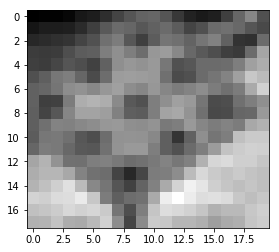

In [122]:
#P1860639.JPG
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

#im_path = './data/MTSD/Images/'
#im_path = './testing_images'

#label_path = './data/test3/labels/'
#label_path = './testing_images'

#fname = '56_2015.jpg'
fname = '88.jpg' #'72.jpg' #'P1860639.JPG'

im = cv2.imread(os.path.join(im_path, fname))


gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
b,g,r = cv2.split(im)       # get b,g,r
rgb_img = cv2.merge([r,g,b])
plt.figure(figsize=(200,100))
plt.imshow(rgb_img)
plt.show()
f = open(os.path.join(label_path, fname.split('.')[0]+'.txt'), 'r')
lines = f.readlines()
for line in lines:
    spl = line.split(' ')

    x1 = int(spl[1])#+1
    y1 = int(spl[2])#+1
    x2 = int(spl[3])#-1
    y2 = int(spl[4])#-1
    fm = 0
    fm = variance_of_laplacian(gray[y1:y2+1,x1:x2+1])
    print('blur factor = ',fm, (fm/float((y2-y1)*(x2-x1))))
    plt.imshow(rgb_img[y1:y2+1,x1:x2+1,0],cmap='gray')
    plt.show()
f.close()


In [14]:
## testing the DCT
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt


def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

#im_path = './data/MTSD/Images/'
files = [f for f in os.listdir(im_path) if os.path.isfile(os.path.join(im_path,f))]
#label_path = './data/test3/labels/'
gt_out_p = './data/MTSD/Annotations/gt_blur_filter2.txt'
gt_out_f = open(gt_out_p, 'w')

#fname = files[1002] #[1137] #[1002] #[1102]
#print(fname)

for fname in files:
    if fname.split('.')[1] == 'txt':
        continue
    if not os.path.exists(os.path.join(label_path, fname.split('.')[0]+'.txt')):
        continue
    im = cv2.imread(os.path.join(im_path, fname))
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    #print(im)
    
    f = open(os.path.join(label_path, fname.split('.')[0]+'.txt'), 'r')
        
    lines = f.readlines()
    for line in lines:
        spl = line.split(' ')

        x1 = int(spl[1])#+1
        y1 = int(spl[2])#+1
        x2 = int(spl[3])#-1
        y2 = int(spl[4])#-1
        fm = 0
        fm = variance_of_laplacian(gray[y1:y2+1,x1:x2+1])
        print('blur factor = ',fm, (fm/float((y2-y1)*(x2-x1))))
        #plt.imshow(gray[y1:y2+1,x1:x2+1])
        #plt.show()

        if fm < 4000:
            gt_out_f.write(fname +";"+ str(x1) + ";" +str(y1) + ";" + str(x2) + ";" + str(y2)+";"+str(np.where(classes == spl[0])[0][0])+'\n')

    f.close()
gt_out_f.close()

('blur factor = ', 111.50961100313546, 0.0015584851293240455)
('blur factor = ', 218.14059540791595, 0.03244208735989232)
('blur factor = ', 51.98667920624425, 0.00029401902115355256)
('blur factor = ', 68.72494093548337, 0.0004316893274841921)
('blur factor = ', 157.31856113009982, 0.07121709421914886)
('blur factor = ', 116.42279398605302, 0.007886654517413157)
('blur factor = ', 21.27032161168843, 0.00034172485077579254)
('blur factor = ', 41.29892977194014, 0.001507810506460027)
('blur factor = ', 464.0349409311049, 0.15918865898151113)
('blur factor = ', 340.26718650030875, 0.05891052397858531)
('blur factor = ', 267.82068732217823, 0.07199480841994038)
('blur factor = ', 25.43755463156359, 0.0006974543384394491)
('blur factor = ', 64.48380366927191, 0.0010965514347051645)
('blur factor = ', 57.805299476553984, 0.0009630203994427986)
('blur factor = ', 31.909164446936757, 0.000590516774871137)
('blur factor = ', 95.5918391125234, 0.0006910120222684146)
('blur factor = ', 58.543422

('blur factor = ', 19.93599591319546, 0.00010045853319826384)
('blur factor = ', 38.18413394769673, 0.013885139617344265)
('blur factor = ', 45.77166663932646, 0.0077212663021805775)
('blur factor = ', 20.927961977498434, 0.0003402920646747713)
('blur factor = ', 34.53911501637692, 0.004000824164992114)
('blur factor = ', 40.79498178899628, 0.004291498189458898)
('blur factor = ', 50.28188547808996, 0.009263427685720332)
('blur factor = ', 69.12746906656658, 0.021335638600792153)
('blur factor = ', 100.22570497918387, 0.015296963519411459)
('blur factor = ', 33.66753631476262, 0.001238779024018052)
('blur factor = ', 41.75057820350981, 0.0026379337968983263)
('blur factor = ', 47.21202124397968, 0.008394740619484295)
('blur factor = ', 44.38726871917783, 0.0017958920828280399)
('blur factor = ', 103.93663150152753, 0.0010087017808766258)
('blur factor = ', 159.05746578451243, 0.0052425005202542)
('blur factor = ', 120.18052438851235, 0.0034926046029791443)
('blur factor = ', 472.201394

('blur factor = ', 57.287562311927324, 0.0014762933207557614)
('blur factor = ', 101.86057052427842, 0.003264761875778154)
('blur factor = ', 30.805273033448557, 7.350795571533562e-05)
('blur factor = ', 114.89290387464848, 0.0014707609497766005)
('blur factor = ', 128.6801680810635, 0.017872245566814375)
('blur factor = ', 113.36590205900825, 0.020207825678967603)
('blur factor = ', 176.3244703513454, 0.01630218845704007)
('blur factor = ', 336.31906107122603, 0.019342020995584658)
('blur factor = ', 35.6784904518112, 0.00031429808886530066)
('blur factor = ', 6080.974930555556, 61.42398919753087)
('blur factor = ', 392.41751892089843, 0.06287734640616863)
('blur factor = ', 2798.5075347618235, 3.7017295433357456)
('blur factor = ', 6454.568499342538, 48.898246207140446)
('blur factor = ', 45.29172582366812, 0.0006236124610848175)
('blur factor = ', 74.22734547586994, 0.017407914042183382)
('blur factor = ', 110.00484659933915, 0.040682265754193474)
('blur factor = ', 317.565402735758

('blur factor = ', 193.87165235387133, 0.030675894359789766)
('blur factor = ', 565.3192515432098, 1.068656430138393)
('blur factor = ', 1929.4598000204062, 5.4046492997770486)
('blur factor = ', 116.50480908599242, 0.007340272749873514)
('blur factor = ', 101.20384859872686, 0.016659069728185493)
('blur factor = ', 852.920203402367, 0.34130460320222766)
('blur factor = ', 203.08880622364646, 0.006669583127213348)
('blur factor = ', 140.07797034799842, 0.003780373788200961)
('blur factor = ', 120.04437034468422, 0.0033640008503484442)
('blur factor = ', 18.614516603380242, 0.0007722584053841787)
('blur factor = ', 36.23610774619615, 0.007946514856621963)
('blur factor = ', 60.971477820518096, 0.0030026335969919283)
('blur factor = ', 72.73972671737148, 0.0279768179682198)
('blur factor = ', 1058.3620894867017, 0.07745624191208297)
('blur factor = ', 36.95621573621789, 0.0003254190616494333)
('blur factor = ', 44.12258095105135, 0.0005816470372413108)
('blur factor = ', 101.278485461790

('blur factor = ', 42.165750719723704, 0.0001748513415593638)
('blur factor = ', 13.531113771908132, 0.0004042396490278174)
('blur factor = ', 948.0590593197186, 2.1497937853054845)
('blur factor = ', 53.194479019985145, 0.00017555470159198814)
('blur factor = ', 72.97619088896974, 0.0013522874249785924)
('blur factor = ', 154.04598367473326, 0.1556020037118518)
('blur factor = ', 28.35481625766951, 0.0009641216000567667)
('blur factor = ', 42.80882921619375, 0.0007622654774963275)
('blur factor = ', 52.20576439227843, 0.0006122909631643084)
('blur factor = ', 131.94654259873724, 0.029919850929418877)
('blur factor = ', 39.32565586843237, 0.0005374560047619567)
('blur factor = ', 81.35387400119822, 0.004740625488094996)
('blur factor = ', 52.83362774655582, 0.001612748099711716)
('blur factor = ', 122.24837431241752, 0.004463248423235397)
('blur factor = ', 181.424017066545, 0.00658406884654491)
('blur factor = ', 39.812788911212664, 0.00019448004978268543)
('blur factor = ', 147.74753

('blur factor = ', 66.07661579188346, 0.004332324665085461)
('blur factor = ', 32.96981598096222, 0.0025907446158228995)
('blur factor = ', 146.09658554738257, 0.0043388152039493515)
('blur factor = ', 58.76078207911042, 0.0007159313572677813)
('blur factor = ', 41.44316770265824, 0.00046205061322561426)
('blur factor = ', 165.05467544367283, 0.03274244702314478)
('blur factor = ', 129.97784779932286, 0.02341943203591403)
('blur factor = ', 46.751710009907036, 0.014950978576881048)
('blur factor = ', 73.61188480228368, 0.0011410572420988915)
('blur factor = ', 37.52152425847694, 0.008375340236267173)
('blur factor = ', 1212.7391033975916, 3.3687197316599766)
('blur factor = ', 649.0407779085559, 0.28795065568258915)
('blur factor = ', 1302.66484375, 1.4490153990545052)
('blur factor = ', 28.735360477253536, 0.0004250855852490945)
('blur factor = ', 119.18252316868778, 0.006258600176899006)
('blur factor = ', 123.77294968707163, 0.005152054182778539)
('blur factor = ', 421.9253969280484

('blur factor = ', 18.446640184956973, 0.00037607829123255805)
('blur factor = ', 23.15696000576701, 0.0023159275933360346)
('blur factor = ', 25.03143353575156, 0.0024538215406089167)
('blur factor = ', 10.41727635215406, 0.004340531813397525)
('blur factor = ', 2666.357219013481, 1.1850476528948803)
('blur factor = ', 2727.7571132122025, 0.9020360824114426)
('blur factor = ', 3774.1489151293017, 1.2253730243926304)
('blur factor = ', 17.14027680592356, 0.00026637258622660824)
('blur factor = ', 47.777333314607425, 0.001496783625144343)
('blur factor = ', 63.78097155228936, 0.0018470106438170206)
('blur factor = ', 64.04970715802112, 0.002316445105172554)
('blur factor = ', 49.74357587796259, 0.0015352955517889688)
('blur factor = ', 50.15916985413866, 0.0005626694694502065)
('blur factor = ', 319.89794587710935, 0.023570435151570097)
('blur factor = ', 1508.2325138504157, 1.164658311853603)
('blur factor = ', 64.74072987728673, 0.002407166011425422)
('blur factor = ', 132.97586308070

('blur factor = ', 83.86640672083752, 0.0031767578303347546)
('blur factor = ', 132.80707373125722, 0.01328203557668339)
('blur factor = ', 1046.6039555266573, 0.3727222063841372)
('blur factor = ', 86.67308648789465, 0.0035615173606136853)
('blur factor = ', 108.60440657920984, 0.004580145351687324)
('blur factor = ', 191.43569577808262, 0.2538934957269)
('blur factor = ', 14.195089969061737, 0.00024425862460744624)
('blur factor = ', 109.52949121557423, 0.023815936337372088)
('blur factor = ', 83.47275890341528, 0.016571919575821974)
('blur factor = ', 65.5880319394003, 0.0621098787304927)
('blur factor = ', 84.50645486351402, 0.017051342789248188)
('blur factor = ', 370.5344847654332, 0.08637167477049724)
('blur factor = ', 35.96475420293143, 0.002893383282617171)
('blur factor = ', 35.86157756493013, 0.006049523880723706)
('blur factor = ', 57.89786700569456, 0.04873557828762168)
('blur factor = ', 66.26557582406468, 0.0458902879668038)
('blur factor = ', 46.60947545901056, 0.00365

('blur factor = ', 87.99531036922819, 0.004645513164883761)
('blur factor = ', 187.62497110848125, 0.03961675910229756)
('blur factor = ', 201.52738925505065, 0.04240896238532211)
('blur factor = ', 43.86478333473029, 0.0023829195640335883)
('blur factor = ', 179.00346786677989, 0.011737932319133107)
('blur factor = ', 349.5629925320257, 0.2022933984560334)
('blur factor = ', 386.74877257665736, 0.08615477223806134)
('blur factor = ', 248.03619155393073, 0.02293234019544478)
('blur factor = ', 84.68512957335666, 0.003129531765460335)
('blur factor = ', 177.85762721125607, 0.06099369931798905)
('blur factor = ', 22.3474291513305, 0.0004134125564475821)
('blur factor = ', 16.65480172357008, 0.0012594375169063885)
('blur factor = ', 302.49263601420137, 0.012838156184288319)
('blur factor = ', 61.48699388704811, 0.0008130941654705454)
('blur factor = ', 46.2961972423378, 0.00301113477998945)
('blur factor = ', 38.26458984381056, 0.0015623301422427961)
('blur factor = ', 978.0036608905972, 

('blur factor = ', 84.77338541516845, 0.0011588662704392011)
('blur factor = ', 93.80361654868835, 0.001248384569452866)
('blur factor = ', 94.83532696944982, 0.002120646846365157)
('blur factor = ', 253.16918707750293, 0.026207990380693883)
('blur factor = ', 179.94049874483778, 0.01798505734581087)
('blur factor = ', 54.4823870711481, 0.0001677227495448414)
('blur factor = ', 56.64598750147941, 0.0002090890509360006)
('blur factor = ', 131.36908065367405, 0.0021446612572839988)
('blur factor = ', 124.99297698675498, 0.002108518505174679)
('blur factor = ', 154.05706421787033, 0.016040927136387998)
('blur factor = ', 283.2547178788767, 0.0064643461107051145)
('blur factor = ', 317.1255516625611, 0.006958169906585947)
('blur factor = ', 401.81262806502286, 0.095103580607106)
('blur factor = ', 401.9836505735376, 0.11001194596976946)
('blur factor = ', 100.62311289353289, 0.07554287754769737)
('blur factor = ', 266.62846788194446, 0.19533221090252342)
('blur factor = ', 92.4255706504485

('blur factor = ', 148.52333406503175, 0.006339024074478521)
('blur factor = ', 249.70563213284336, 0.08892650716981601)
('blur factor = ', 409.1057422178567, 0.14564106166531032)
('blur factor = ', 403.596978799056, 0.015765506984338123)
('blur factor = ', 61.92674490593796, 0.0004969844300464505)
('blur factor = ', 13.711508625572112, 9.305022276372942e-05)
('blur factor = ', 30.35274128171776, 0.00016889657497394587)
('blur factor = ', 25.737826806465712, 0.00015463819661537087)
('blur factor = ', 34.99061800804363, 0.00867822867262987)
('blur factor = ', 79.24959831117894, 0.0009522902945347145)
('blur factor = ', 129.41065314035012, 0.01913226687468216)
('blur factor = ', 84.64665615251383, 0.006943942260255441)
('blur factor = ', 89.254017230906, 0.009107552778663878)
('blur factor = ', 22.234440565516145, 0.0004765612261127432)
('blur factor = ', 43.81883580618575, 0.001135438324165261)
('blur factor = ', 77.98700565241757, 0.003469635879005987)
('blur factor = ', 1131.183595749

('blur factor = ', 84.73441249037919, 0.00167389843129095)
('blur factor = ', 86.02469627223508, 0.0018438077904714308)
('blur factor = ', 88.09291176714768, 0.008817226680727423)
('blur factor = ', 36.05319659684946, 0.0014442653766313929)
('blur factor = ', 43.503115258839074, 0.0017101625622627202)
('blur factor = ', 33.27901611677807, 0.0004548302005901223)
('blur factor = ', 25.543374016496404, 0.0005306280696434502)
('blur factor = ', 46.00666549634264, 0.0007710183592482426)
('blur factor = ', 51.99413421546496, 0.0008189600273353226)
('blur factor = ', 58.810593639559144, 0.00027264489133052306)
('blur factor = ', 43.547804724686, 0.0006393089056283454)
('blur factor = ', 61.849516395800784, 0.003716918052632259)
('blur factor = ', 64.40112001800804, 0.025334822981120393)
('blur factor = ', 117.5683864554163, 0.06358484935392986)
('blur factor = ', 166.3589475410325, 0.13591417282764093)
('blur factor = ', 89.38759768666044, 0.002940961955868278)
('blur factor = ', 33.175474792

('blur factor = ', 17.380726147052346, 0.00013921063456774697)
('blur factor = ', 34.74406756233858, 0.0004823153362532425)
('blur factor = ', 1205.4430492154127, 0.12300439277708293)
('blur factor = ', 23.33691420046356, 0.00016204164896376538)
('blur factor = ', 20.509278020673314, 0.00014981320550678466)
('blur factor = ', 47.857069346063646, 0.005976157510747209)
('blur factor = ', 41.207964310896536, 0.005706683881857988)
('blur factor = ', 145.2447833539643, 0.005976167847019597)
('blur factor = ', 206.62511268083583, 0.07095642605797933)
('blur factor = ', 77.19290324062962, 0.006679898168971065)
('blur factor = ', 60.59626914509626, 0.06515727865064114)
('blur factor = ', 96.580475, 0.0419368106817195)
('blur factor = ', 142.9525859184382, 0.06618175274001768)
('blur factor = ', 18.15273947845784, 0.0001756331463916738)
('blur factor = ', 110.90960192856858, 0.0019098636507881351)
('blur factor = ', 78.89202504778443, 0.001386990595073566)
('blur factor = ', 164.193948962058, 0

('blur factor = ', 316.6149868721707, 0.2284379414662126)
('blur factor = ', 67.30578656635092, 0.01016396656091074)
('blur factor = ', 67.10146501088376, 0.002106135122752158)
('blur factor = ', 22.992438218021267, 0.0010791025586906306)
('blur factor = ', 37.11730835554558, 0.0010786779527912113)
('blur factor = ', 28.173276204246257, 0.0005983111664170544)
('blur factor = ', 73.86469823669648, 0.0028145365888087364)
('blur factor = ', 69.38155089149124, 0.0007976908056231604)
('blur factor = ', 1446.308476454294, 3.3479362880886434)
('blur factor = ', 23.514040906360968, 0.0002830902326739179)
('blur factor = ', 109.84161607685522, 0.01109511273503588)
('blur factor = ', 37.958068934932996, 0.011060043395959498)
('blur factor = ', 48.091705281362266, 0.0009487601902062039)
('blur factor = ', 47.61569027468991, 0.0007967286372178888)
('blur factor = ', 32.47431800847696, 0.001668772765081036)
('blur factor = ', 27.508023397199, 0.0013648237855221534)
('blur factor = ', 166.5722642651

('blur factor = ', 113.73743561945493, 0.015623274123551502)
('blur factor = ', 35.730150795317066, 0.0004121695136041559)
('blur factor = ', 61.4277603945224, 0.02378155648258707)
('blur factor = ', 103.20047520980779, 0.04047077459208149)
('blur factor = ', 41.53345435376068, 0.000625739425292063)
('blur factor = ', 107.23670096783673, 0.0026151465875197955)
('blur factor = ', 127.28620779047176, 0.03477765240176824)
('blur factor = ', 1052.6631116150165, 0.2148730580965537)
('blur factor = ', 189.77788597601767, 0.004032336519973178)
('blur factor = ', 118.2457235661935, 0.0020529127860933957)
('blur factor = ', 56.04563883505839, 0.021622545846858948)
('blur factor = ', 36.447813457291645, 0.0007396816531160151)
('blur factor = ', 33.02453928009251, 8.675303811957378e-05)
('blur factor = ', 89.60652638140971, 0.0010331902774353117)
('blur factor = ', 70.6637810633182, 0.0006494832818319687)
('blur factor = ', 40.70039422048256, 0.0006725670366104694)
('blur factor = ', 165.03986379

In [126]:
#gt_in_p = './data/MTSD/Annotations/gt_blur_filter.txt'
gt_in_f = open(anno_file_path, 'r')

lines = gt_in_f.readlines()
dic = {}

for line in lines:
    spl = line.split(';')
    if dic.has_key(spl[0]):
        dic[spl[0]].append(line)
    else:
        dic[spl[0]] =[line]
        
print(len(dic))

print(dic.items()[0])
#print(dic['56_2015.jpg'])
print(dic['88.jpg'])

485
('P1840472.JPG', ['P1840472.JPG;3472;1169;3707;1400;0\n'])
['88.jpg;479;592;505;613;9\n', '88.jpg;517;572;535;587;9\n', '88.jpg;518;552;537;569;6\n']


In [131]:
print(dic.items()[1][1])

['P1840363.JPG;1480;1553;1665;1775;6\n', 'P1840363.JPG;1437;1799;1667;2021;9\n']


('P1860368.JPG', ['P1860368.JPG;3372;1646;3573;1864;48\n', 'P1860368.JPG;464;1545;745;1846;43\n'])
976 / 977


Button(description=u'Next', style=ButtonStyle())

Button(description=u'Back', style=ButtonStyle())

blur factor =  45.98536465887846 0.0010494628841772435
blur factor =  36.22664957300177 0.00042830717978034985


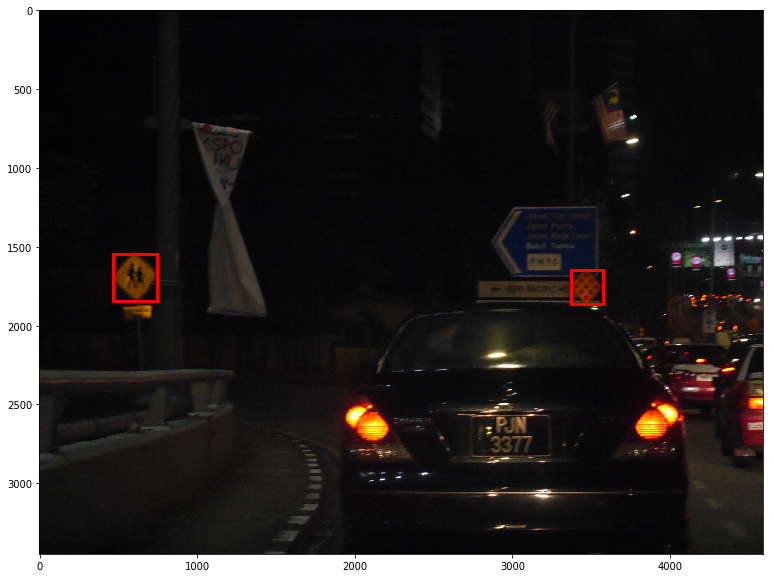

In [302]:
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
import matplotlib.image as mpimg

%matplotlib inline
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual#, Button
import ipywidgets as widgets
from IPython import display

import matplotlib.patches as patches


i=0
button_next = widgets.Button(description="Next")
button_back = widgets.Button(description="Back")

#im_path = './data/MTSD/Images/'
#gt_in_p = './data/MTSD/Annotations/gt_blur_filter.txt'
gt_in_f = open(anno_file_path, 'r')

lines = gt_in_f.readlines()
dic = {}

for line in lines:
    spl = line.split(';')
    if dic.has_key(spl[0]):
        dic[spl[0]].append(line)
    else:
        dic[spl[0]] = [line]

print(i+1,'/',len(dic))
display.display(button_next,button_back)
#display.display(button_no)
fig,ax = plt.subplots(1, figsize = (20,10))
#plt.figure(figsize=(200,100))
ax.imshow( Image.open( os.path.join(im_path,dic.items()[i][0]) ) )
for k in dic.items()[i][1]:
    sp = k.split(';')
    rect = patches.Rectangle((int(sp[1]),int(sp[2])),int(sp[3])-int(sp[1]),int(sp[4])-int(sp[2]),linewidth=3,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

plt.show()

def on_click_next(b):
    #print("yes")
    global i
    
    i=i+1
    found = False
    while (not found) and (i<len(dic)):
        for k in dic.items()[i][1]:
            if k.split(';')[5] == '62\n':
                found = True

        i = i+1
    i=i-1
    display.clear_output()
    print(dic.items()[i])
    if i>= len(dic):
        print("Finish")
        return
    
    print(i,'/',len(dic))
    display.display(button_next)
    display.display(button_back)
    fig,ax = plt.subplots(1, figsize = (20,10))
    ax.imshow( Image.open( os.path.join(im_path,dic.items()[i][0]) ) )
    im = cv2.imread(os.path.join(im_path, dic.items()[i][0]))
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    for k in dic.items()[i][1]:
        sp = k.split(';')
        x1 = int(sp[1])
        y1 = int(sp[2])
        x2 = int(sp[3])
        y2 = int(sp[4])
        rect = patches.Rectangle((int(sp[1]),int(sp[2])),int(sp[3])-int(sp[1]),int(sp[4])-int(sp[2]),linewidth=3,edgecolor='r',facecolor='none')
        fm = variance_of_laplacian(gray[y1:y2+1,x1:x2+1])
        print('blur factor = ',fm, (fm/float((y2-y1)*(x2-x1))))
        ax.add_patch(rect)
    plt.show()
    
def on_click_back(b):
    global i
    
    if i==0:
        return
              
    i=i-1
    
    display.clear_output()
    
    
    print(i+1,'/',len(dic))
    display.display(button_next)
    display.display(button_back)
    fig,ax = plt.subplots(1, figsize = (20,10))
    ax.imshow( Image.open( os.path.join(im_path,dic.items()[i][0]) ) )
    for k in dic.items()[i][1]:
        sp = k.split(';')
        rect = patches.Rectangle((int(sp[1]),int(sp[2])),int(sp[3])-int(sp[1]),int(sp[4])-int(sp[2]),linewidth=3,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    plt.show()

    
button_next.on_click(on_click_next)
button_back.on_click(on_click_back)

In [133]:
cls_num

4

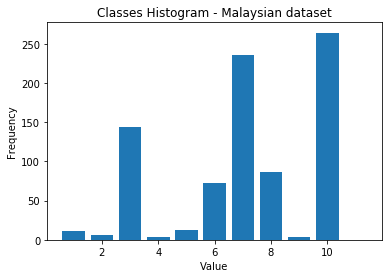

len 10
11
6
144
4
12
72
235
87
4
264
freq->
 [ 11   6 144   4  12  72 235  87   4 264]
Mean: 83.90
 Var: 8835.09
 Max: 264.00
 Min: 4.00
 Sum: 839.00
 STD: 94.00
 CV: 1.12

Total number of objects: 839


In [134]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

#file_p = 'data/MTSD/Annotations/gt_blur_filter.txt'


file = open(anno_file_path,'rt')


tmp = []
for line in file:
    tmp.append( int(line.split(';')[5].replace('\r\n',''))+1)
#plt.hist(x, normed=True, bins=30)
# hist, bins = np.histogram(tmp, bins=66)
# width = 0.7 * (bins[1] - bins[0])
# center = (bins[:-1] + bins[1:]) / 2
# plt.bar(center, hist, align='center', width=width)
# plt.legend()
# plt.show()

plt.hist(tmp,histtype='bar', rwidth=0.8,bins=range(1,num_cls+3,1), align='left')
###plt.hist(tmp,histtype='bar', rwidth=0.8,bins=range(1,50,1), align='left')
plt.title("Classes Histogram - Malaysian dataset")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.show()

#print tmp
file.close()
a = np.array(tmp)
unique, counts = np.unique(a, return_counts=True)

frq = np.array(counts)
# print counts
keep = np.where(frq < 50)
# print keep
# print classes[keep]
# print a.mean(), a.var(), a.max(), a.min(), a.sum(), a.std()
# print frq.mean(), frq.var(), frq.max(), frq.min(), frq.sum(), frq.std()
# print len(tmp)

print('len',len(counts))

for ck in counts:
    print(ck)

print('freq->\n',counts)
#print keep
#print classes[keep]
#print a.mean(), a.var(), a.max(), a.min(), a.sum(), a.std()
print('Mean: {:.2f}\n'.format(frq.mean()),\
    'Var: {:.2f}\n'.format(frq.var()),\
    'Max: {:.2f}\n'.format(frq.max()),\
    'Min: {:.2f}\n'.format(frq.min()),\
    'Sum: {:.2f}\n'.format(frq.sum()),\
    'STD: {:.2f}\n'.format(frq.std()),\
    'CV: {:.2f}\n'.format(frq.std()/frq.mean()) )
print('Total number of objects:',len(tmp))

## 2) Loop for each image
### - blur the objects that is not in keep array
### - store only the images that have at least one object in keep array in aug folder
### - store aswell the labels for each image obj in aug folder in aug_labels

In [222]:
#im_path = './data/MTSD/Images/'
files = [f for f in os.listdir(im_path) if os.path.isfile(os.path.join(im_path,f))]
#mask_path = './data/test/gt/'
#label_path = './data/test3/labels/'

#fname = 'P1840185.JPG'
#fname = 'P1840114.JPG'
#fname = 'P1840116.JPG'
#fname = 'P1860061.JPG'

#keep = [0,2,3,4,5,6,8,9,10,11]

for fname in files:
    if fname.split('.')[1] == 'txt':
        continue
    #print fname
    if not os.path.isfile(os.path.join(label_path, fname.split('.')[0]+'.txt')):
        #fault = open('faults.txt', 'a')
        #fault.write(fil+'\n')
        continue
    
    store = False

    im = cv2.imread(os.path.join(im_path, fname))
    org = im.copy()
    f = open(os.path.join(label_path, fname.split('.')[0]+'.txt'), 'r')
    
    lines = f.readlines()
    text = ''
    for line in lines:
        spl = line.split(' ')
        i = np.where(classes == spl[0])[0][0]
        if i not in keep[0]:
            x1 = int(spl[1])#+1
            y1 = int(spl[2])#+1
            x2 = int(spl[3])#-1
            y2 = int(spl[4])#-1

            #print y2-y1, x2-x1

            #cv2.imwrite('without_aug.jpg', im)
            #print im[y1:y2,x1:x2]

            np.random.shuffle(im[y1:y2+1,x1:x2+1,0])
            np.random.shuffle(im[y1:y2+1,x1:x2+1,0].T)

            np.random.shuffle(im[y1:y2+1,x1:x2+1,1])
            np.random.shuffle(im[y1:y2+1,x1:x2+1,1].T)

            np.random.shuffle(im[y1:y2+1,x1:x2+1,2])
            np.random.shuffle(im[y1:y2+1,x1:x2+1,2].T)

            #np.random.shuffle(im[y1:y2,x1:x2])
            #np.random.shuffle(im[y1:y2,x1:x2].T)

            blur = cv2.blur(im, (50, 50))

            #print lines[0] , x1, x2, y1, y2

            #print im[y1:y2,x1:x2,0]
            #cv2.imwrite('aug.jpg', im)

            num =10
            im[y1-num:y2+num,x1-num:x2+num] = blur[y1-num:y2+num,x1-num:x2+num]
            #cv2.imwrite('aug_blur.jpg', im)

    for line in lines:
        spl = line.split(' ')
        i = np.where(classes == spl[0])[0][0]
        if i in keep[0]:
            store = True
            
            #spl = line.split(' ')
            x1 = int(spl[1])#+1
            y1 = int(spl[2])#+1
            x2 = int(spl[3])#-1
            y2 = int(spl[4])#-1
            text += line
            #im2 = cv2.imread(os.path.join(im_path, fname))
            ynum = int(y2-y1)/14
            xnum = int(x2-x1)/14
            im[y1-ynum:y2+ynum,x1-xnum:x2+xnum] = org[y1-ynum:y2+ynum,x1-xnum:x2+xnum]
    
    if store:
        cv2.imwrite(os.path.join(aug_path,fname.split('.')[0]+'_aug'+'.jpg'), im)
        f_out = open(os.path.join(aug_labels_path, fname.split('.')[0]+'_aug'+'.txt'), 'w')
        f_out.write(text)
        f_out.close()

## 3) Generate the mask image for each aug image

In [304]:
#im_path = './data/test3/aug/'
files = [f for f in os.listdir(im_path) if os.path.isfile(os.path.join(im_path,f))]

In [305]:
'56_2015_aug.jpg' in files

True

In [231]:
#mask_path = './data/test3/aug_gt/'
#label_path = './data/test3/aug_labels/'

for fil in files:
    if not os.path.isfile(os.path.join(label_path, fil.split('.')[0]+'.txt')):
        #fault = open('faults.txt', 'a')
        #fault.write(fil+'\n')
        continue
    im = cv2.imread(os.path.join(im_path, fil))
    f = open(os.path.join(label_path, fil.split('.')[0]+'.txt'))
    #print os.path.join(label_path, fil.split('.')[0]+'.txt')
    lines = f.readlines()
    im_out = np.zeros(im.shape, np.uint8)
    for i, line in enumerate(lines):
        spl = line.split(' ')
        x1 = int(spl[1])#+1
        y1 = int(spl[2])#+1
        x2 = int(spl[3])#-1
        y2 = int(spl[4])#-1
        #print fil, i, line
        cv2.rectangle(im_out, (x1,y1), (x2,y2),color_list[i], -1)
    #print '______'
    cv2.imwrite(os.path.join(aug_gt_path, fil), im_out)

## 4) Augment the images with ground truth mask

In [232]:
import Augmentor

In [233]:
p = Augmentor.Pipeline(aug_path)
p.ground_truth(aug_gt_path)

Initialised with 523 image(s) found.
Output directory set to ./data/test3/aug/output.523 ground truth image(s) found.


In [234]:
p.rotate(probability=0.4, max_left_rotation=5, max_right_rotation=5)
p.zoom(probability=0.3, min_factor=1.05, max_factor=1.1)
p.random_distortion(probability=0.7, grid_width=2, grid_height=2, magnitude=5)
p.skew_tilt(probability=0.5, magnitude=0.2)
p.skew(probability=0.5, magnitude=0.2)

#p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
#p.zoom(probability=0.5, min_factor=1.1, max_factor=1.2)
#p.random_distortion(probability=0.7, grid_width=4, grid_height=4, magnitude=8)
#p.skew_tilt(probability=0.5, magnitude=0.3)
#p.skew(probability=0.5, magnitude=0.3)

In [235]:
#p.remove_operation(operation_index=0)

p.status()

Operations: 5
	0: RotateRange (max_right_rotation=5.0 max_left_rotation=-5.0 probability=0.4 )
	1: Zoom (min_factor=1.05 max_factor=1.1 probability=0.3 )
	2: Distort (randomise_magnitude=True magnitude=5 grid_height=2 probability=0.7 grid_width=2 )
	3: Skew (magnitude=0.2 skew_type=TILT probability=0.5 )
	4: Skew (magnitude=0.2 skew_type=RANDOM probability=0.5 )
Images: 523
Classes: 1
	Class index: 0 Class label: aug 
Dimensions: 21
	Width: 1918 Height: 983
	Width: 1917 Height: 977
	Width: 1919 Height: 981
	Width: 1920 Height: 981
	Width: 1917 Height: 979
	Width: 1920 Height: 985
	Width: 1919 Height: 979
	Width: 1920 Height: 979
	Width: 3920 Height: 2208
	Width: 1920 Height: 1080
	Width: 1917 Height: 981
	Width: 1919 Height: 977
	Width: 1920 Height: 977
	Width: 1915 Height: 981
	Width: 3840 Height: 2160
	Width: 1919 Height: 983
	Width: 1915 Height: 975
	Width: 1917 Height: 983
	Width: 4592 Height: 3448
	Width: 1917 Height: 975
	Width: 1920 Height: 983
Formats: 1
	 JPEG

You can remove 

In [236]:
#p.sample(395*10, multi_threaded=True)
p.sample(44*100, multi_threaded=True)

Processing <PIL.Image.Image image mode=RGB size=3920x2208 at 0x7F9ACDA32F50>: 100%|██████████| 4400/4400 [21:35<00:00,  3.40 Samples/s]                   


## 5) Create the annotation for the new augmented images

In [335]:
#aug_path = './data/test3/aug/output/'
files = [f for f in os.listdir(aug_output_path) if os.path.isfile(os.path.join(aug_path,f))]

gts = []
augs = []

for fi in files:
    if 'original' in fi:
        augs.append(fi)
    else:
        gts.append(fi)

In [336]:
augs

['aug_original_39_aug.jpg_0c9cfb88-9da2-4e8a-95f4-456f7716a76d.jpg',
 'aug_original_P1860062_aug.jpg_4b478320-fb8e-411f-96c0-2c4eeaefecc0.jpg',
 'aug_original_P1840375_aug.jpg_512374fa-ac2f-4982-85a4-4bc19afeb151.jpg',
 'aug_original_P1840318_aug.jpg_a84eb7a2-1bc3-4ad3-ab2c-9752919129d7.jpg',
 'aug_original_135_aug.jpg_bd387659-f181-4893-b5e4-0df075baf52c.jpg',
 'aug_original_61_aug.jpg_fa4d418c-f6a6-447c-9291-5cd96e0f8d37.jpg',
 'aug_original_P1860653_aug.jpg_207e28b0-86dd-4cb1-827d-2b231b37b44b.jpg',
 'aug_original_P1840217_aug.jpg_38966872-5db6-4d98-9e0c-ba0561f0f6cd.jpg',
 'aug_original_29_aug.jpg_872698ce-d21d-4d75-9fc2-05feaf51b749.jpg',
 'aug_original_119_aug.jpg_a7e9070f-10ff-4c72-af51-c44d83deba0d.jpg',
 'aug_original_DSC-0130_aug.jpg_0d3b341f-2584-4973-bb0f-df4bdb0caa75.jpg',
 'aug_original_P1840089_aug.jpg_f1dfb99a-5455-4cb2-8055-7cf55487121b.jpg',
 'aug_original_P1840510_aug.jpg_1d17bee1-46d8-4d94-9384-699f53bcda2e.jpg',
 'aug_original_P1840285_aug.jpg_3997b6f4-a8fe-4302-9d

In [337]:
#mask_path = './data/test3/aug_gt/'
#label_path = './data/test3/aug_labels/'

print(gts[0].split('_')[6] in augs[0].split('_')[4])
print(gts[0])
print(augs[0])
x = 'aug_original_49_aug.jpg_45daa9b6-92a4-4fc2-893e-f08ac42f23d1.jpg'
y = x.replace('aug_original_', '_groundtruth_(1)_aug_')
print(y, os.path.isfile(os.path.join(aug_path, y)))
print(len(augs), len(gts))

print(label_path, aug_gt_path)

False
_groundtruth_(1)_aug_P1840507_aug.jpg_e8d43073-b332-4203-81f0-c5e40760c67b.jpg
aug_original_39_aug.jpg_0c9cfb88-9da2-4e8a-95f4-456f7716a76d.jpg
_groundtruth_(1)_aug_49_aug.jpg_45daa9b6-92a4-4fc2-893e-f08ac42f23d1.jpg False
4400 4400
./data/test3/aug_labels/ ./data/test3/aug_gt/


In [338]:
# mask with different colors space per each object sequential

#./data/test/gt/P1840014.JPG
#./data/test/gt/P1840114.JPG
# P1860079.JPG

#ff = '130.jpg'
#mask_gt_path = './data/test3/aug/output/'
#label_path = './data/test3/aug_labels/'

f_out = open('results{}/gt_phase_1.txt'.format(experiment), 'w')
for aug in augs:
    aug_sp = aug.split('_')
    gt = aug.replace('aug_original_', '_groundtruth_(1)_aug_')
    
    ############## bug fix if org file name have '_' #############
    org_file =  aug_sp[2] #+'_'+aug_sp[3]
    i=3
    while('aug' not in aug_sp[i]):
        org_file = org_file + '_' + aug_sp[i]
        i=i+1
    org_file = org_file + '_' + aug_sp[i]
    ##############################################################
    
    if not os.path.exists(os.path.join(label_path, org_file.split('.')[0]+'.txt')):
        print(os.path.join(label_path, org_file.split('.')[0]+'.txt'))
        continue
        
    im = cv2.imread(os.path.join(aug_output_path,gt))
    f = open(os.path.join(label_path, org_file.split('.')[0]+'.txt'), 'r')
    
    #im[im == 255] = 1
    #im[im == 0] = 255
    #im[im == 1] = 0
    lines = f.readlines()
    #print 'Number of objects', len(lines)
    for i in range(0, len(lines)):
        lower = np.array(color_list[i])-10
        upper = np.array(color_list[i])+10
        mask = cv2.inRange(im, lower, upper)
        im3 = cv2.bitwise_and(im, im, mask=mask)


        #print 'obj#', i
        im2 = cv2.cvtColor(im3, cv2.COLOR_BGR2GRAY)

        #print np.max(im2), np.min(im2)

        #cv2.imwrite(org_file+str(i)+'_thr.jpg', im2)
        ret, thresh = cv2.threshold(im2, 0, np.max(im2)+1 ,cv2.THRESH_BINARY)
        _, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        #print len(contours), org_file
        if len(contours) == 0:
            continue
        #for i in range(0, len(contours)):
            #if(i%2 == 0)

        # getting the maximum width contours
        x,y,w,h = cv2.boundingRect(contours[0])
        for cnt in contours:
            cx, cy, cw, ch = cv2.boundingRect(cnt)
            if cw*ch > w*h: # bug fix compare the area instead of the width only
                x,y,w,h = cx, cy, cw, ch
        #cnt = contours[i]
        # Fix problem of corner small bbox
        #print im.shape, x,y,w+x,h+y, aug
        #if x == 0 or y == 0 or ((x+w) == im.shape[1]) or ((y+h) == im.shape[0]):
            #nw = float(w)/im.shape[1]
            #nh = float(h)/im.shape[0]
            #ratio = float(max(nw,nh)) / min(nw,nh)
            #if ratio >= 2.5:
                #print('skip->',ratio,nw, nh, aug, x, y, w, h, 'cls',cls_num)
                #continue
        #cv2.rectangle(im, (x,y), (x+w, y+h), (0,240,180), 5)
        cls_num = np.where(classes == lines[i].split(' ')[0])[0][0]
        f_out.write('./output/'+aug+';'+str(x)+';'+str(y)+';'+str(x+w)+';'+str(y+h)+';'+ str(cls_num) +'\n')
        #print (x,y), (x+w, y+h)
        #cv2.imwrite(org_file+str(i)+'.jpg', im)

        #print '_______'
f_out.close()

## filter all corner bbox

In [397]:
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

#mask_gt_path = './data/test3/aug/output/'
#label_path = './data/test3/aug_labels/'
f_anno = open('results{}/gt_phase_1.txt'.format(experiment), 'r')
lines = f_anno.readlines()

outlayer = []
outlayer_index = []

for i, line in enumerate(lines):
        spl = line.split(';')
        fname = spl[0]
        x1 = int(spl[1])#+1
        y1 = int(spl[2])#+1
        x2 = int(spl[3])#-1
        y2 = int(spl[4])#-1
        
        f_fname = os.path.join(aug_path,fname)
        img = Image.open(f_fname)
        #img=mpimg.imread(f_fname)
        #if (x1 == 0) or (x2 == img.shape[1]) or (y1 == 0) or (y2 == img.shape[0]):
        if (x1 == 0) or (x2 == img.width) or (y1 == 0) or (y2 == img.height):
            #print(img.height, img.width)
            #print(f_fname, x1,y1,x2,y2)
            outlayer.append( (f_fname, x1,y1,x2,y2) )
            outlayer_index.append(i)
f_anno.close()

In [340]:
print(len(outlayer))

231


In [71]:
%matplotlib inline
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual#, Button
import ipywidgets as widgets
from IPython import display

import matplotlib.patches as patches

keeping = []
discarding = []

i=0
button_yes = widgets.Button(description="Keep")
button_no = widgets.Button(description="Discard")

print(i+1,'/',len(outlayer))
display.display(button_yes,button_no)
#display.display(button_no)
fig,ax = plt.subplots(1, figsize = (20,10))
ax.imshow(Image.open(outlayer[i][0]))
rect = patches.Rectangle((outlayer[i][1],outlayer[i][2]),outlayer[i][3]-outlayer[i][1],outlayer[i][4]-outlayer[i][2],linewidth=3,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

def on_click_yes(b):
    #print("yes")
    global i
    
    keeping.append(i)
    i=i+1
    
    display.clear_output()
    if i>= len(outlayer):
        print("Finish")
        return
    
    print(i+1,'/',len(outlayer))
    display.display(button_yes)
    display.display(button_no)
    fig,ax = plt.subplots(1, figsize = (20,10))
    ax.imshow(Image.open(outlayer[i][0]))
    rect = patches.Rectangle((outlayer[i][1],outlayer[i][2]),outlayer[i][3]-outlayer[i][1],outlayer[i][4]-outlayer[i][2],linewidth=3,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()
    
def on_click_no(b):
    global i
    
    discarding.append(i)
    i=i+1
    
    display.clear_output()
    if i>= len(outlayer):
        print("Finish")
        return
    
    
    print(i+1,'/',len(outlayer))
    display.display(button_yes)
    display.display(button_no)
    fig,ax = plt.subplots(1, figsize = (20,10))
    ax.imshow(Image.open(outlayer[i][0]))
    rect = patches.Rectangle((outlayer[i][1],outlayer[i][2]),outlayer[i][3]-outlayer[i][1],outlayer[i][4]-outlayer[i][2],linewidth=3,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

    
button_yes.on_click(on_click_yes)
button_no.on_click(on_click_no)

Finish


# for testing

In [72]:
print(i)
print(i-2)
print(outlayer[i-2])

268
266
('./data/test4/aug/./output/aug_original_P1840598_aug.jpg_5db7849b-efa5-4288-935e-71de1eb4e5e2.jpg', 0, 602, 117, 866)


In [448]:
# mask with different colors space per each object sequential

#./data/test/gt/P1840014.JPG
#./data/test/gt/P1840114.JPG
# P1860079.JPG

#ff = '130.jpg'
#mask_gt_path = './data/test4/aug/output/'
#label_path = './data/test4/aug_labels/'

aug = 'aug_original_P1840123_aug.jpg_3e6e0608-f4dc-4b0d-b64f-e8f5d650fb97.jpg'
#aug = 'aug_original_P1840009_aug.jpg_f4d4a728-4067-4df1-8352-34689f61fc71.jpg'
#aug = 'aug_original_P1840602_aug.jpg_6184fcf3-90b8-4ec0-9139-28d16f978d96.jpg'
aug_sp = aug.split('_')
gt = aug.replace('aug_original_', '_groundtruth_(1)_aug_')

############## bug fix if org file name have '_' #############
org_file =  aug_sp[2] #+'_'+aug_sp[3]
ii=3
while('aug' not in aug_sp[ii]):
    org_file = org_file + '_' + aug_sp[ii]
    ii=ii+1
org_file = org_file + '_' + aug_sp[ii]
##############################################################

if not os.path.exists(os.path.join(label_path, org_file.split('.')[0]+'.txt')):
    print(os.path.join(label_path, org_file.split('.')[0]+'.txt'))

im = cv2.imread(os.path.join(aug_output_path,gt))
f = open(os.path.join(label_path, org_file.split('.')[0]+'.txt'), 'r')

#im[im == 255] = 1
#im[im == 0] = 255
#im[im == 1] = 0
lines = [f.readlines()[0]]
#lines = f.readlines()
print(lines)
#print 'Number of objects', len(lines)
for ii in range(0, len(lines)):
    lower = np.array(color_list[ii])-10
    upper = np.array(color_list[ii])+10
    mask = cv2.inRange(im, lower, upper)
    im3 = cv2.bitwise_and(im, im, mask=mask)


    #print 'obj#', i
    im2 = cv2.cvtColor(im3, cv2.COLOR_BGR2GRAY)

    #print np.max(im2), np.min(im2)

    #cv2.imwrite(org_file+str(i)+'_thr.jpg', im2)
    ret, thresh = cv2.threshold(im2, 0, np.max(im2)+1 ,cv2.THRESH_BINARY)
    _, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #print len(contours), org_file
    if len(contours) == 0:
        print('no contours')
        
    #for i in range(0, len(contours)):
        #if(i%2 == 0)

    # getting the maximum width contours
    x,y,w,h = cv2.boundingRect(contours[0])
    for cnt in contours:
        cx, cy, cw, ch = cv2.boundingRect(cnt)
        if cw*ch > w*h:
            x,y,w,h = cx, cy, cw, ch
    #cnt = contours[i]
    # Fix problem of corner small bbox
    #print im.shape, x,y,w+x,h+y, aug
    #if x == 0 or y == 0 or ((x+w) == im.shape[1]) or ((y+h) == im.shape[0]):
        #nw = float(w)/im.shape[1]
        #nh = float(h)/im.shape[0]
        #ratio = float(max(nw,nh)) / min(nw,nh)
        #if ratio >= 2.5:
            #print('skip->',ratio,nw, nh, aug, x, y, w, h, 'cls',cls_num)
            #continue
    #cv2.rectangle(im, (x,y), (x+w, y+h), (0,240,180), 5)
    cls_num = np.where(classes == lines[ii].split(' ')[0])[0][0]
    print('./output/'+aug+';'+str(x)+';'+str(y)+';'+str(x+w)+';'+str(y+h)+';'+ str(cls_num) +'\n')
    #print (x,y), (x+w, y+h)
    #cv2.imwrite(org_file+str(i)+'.jpg', im)

    #print '_______'

['crossroads 319 1658 570 1873\n']
./output/aug_original_P1840123_aug.jpg_3e6e0608-f4dc-4b0d-b64f-e8f5d650fb97.jpg;0;1820;252;2042;54



In [73]:
print(len(contours))
print('X1\t','Y1\t','W\t','H')
x,y,w,h = cv2.boundingRect(contours[0])
for cnt in contours:
    cx,cy,cw,ch = cv2.boundingRect(cnt)
    if cw*ch > w*h:
        x,y,w,h = cx, cy, cw, ch
    print(cx,'\t',cy,'\t',cw,'\t',ch)
print('max is ',x,y,w,h)

9
X1	 Y1	 W	 H
2228 	 1223 	 2 	 7
2110 	 1222 	 120 	 100
2144 	 1317 	 17 	 4
2127 	 1313 	 18 	 4
2111 	 1313 	 8 	 4
2111 	 1227 	 12 	 4
2112 	 1223 	 10 	 3
2226 	 1219 	 4 	 1
2113 	 1219 	 111 	 2
max is  2110 1222 120 100


## for testing end

In [74]:
print('keeping:',len(keeping),'/',len(outlayer),'\ndiscarding:', len(discarding),'/', len(outlayer))

keeping: 123 / 268 
discarding: 145 / 268


In [75]:
noutlayer = np.array(outlayer)
noutlayer_index = np.array(outlayer_index)
new_lines = []
mapping_lines = {}
for ii,jj in enumerate(noutlayer_index):
    mapping_lines[jj] = ii
    #print(ii, jj, lines[jj])
for ii, line in enumerate(lines):
    if mapping_lines.has_key(ii):
        if mapping_lines[ii] in discarding:
            continue
    new_lines.append(line)
#print(keeping)
#print(noutlayer[keeping])

In [76]:
print(len(new_lines), len(lines))

4439 4584


In [77]:
!cp ./results4/gt_phase_1.txt ./results4/gt_phase_1.txt.backup

In [78]:
f_out = open('results{}/gt_phase_1.txt'.format(experiment), 'w')
f_out.writelines(new_lines)
f_out.close()

In [79]:
print(discarding)
print(noutlayer[discarding])

[0, 3, 4, 9, 10, 13, 15, 16, 19, 20, 22, 23, 25, 29, 31, 32, 34, 35, 36, 38, 39, 40, 43, 46, 47, 48, 49, 50, 51, 54, 55, 56, 57, 58, 62, 63, 65, 66, 69, 72, 74, 75, 77, 78, 80, 81, 82, 83, 85, 86, 87, 88, 89, 90, 91, 95, 96, 98, 100, 101, 102, 105, 106, 107, 108, 110, 112, 115, 118, 119, 120, 121, 124, 125, 128, 129, 130, 132, 135, 136, 138, 141, 143, 144, 145, 146, 148, 149, 150, 151, 154, 155, 157, 158, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 176, 181, 182, 184, 185, 186, 188, 189, 190, 192, 194, 200, 209, 211, 212, 213, 214, 215, 217, 219, 220, 221, 223, 224, 225, 228, 230, 231, 232, 233, 237, 241, 243, 246, 248, 250, 257, 263, 264, 265, 266]
[['./data/test4/aug/./output/aug_original_P1840002_aug.jpg_739c363a-f43b-4785-9230-66027eb4a9a0.jpg'
  '0' '1288' '147' '1549']
 ['./data/test4/aug/./output/aug_original_P1840139_aug.jpg_0d74505e-478c-4104-987e-231a8e94ab3c.jpg'
  '2231' '0' '3004' '460']
 ['./data/test4/aug/./output/aug_original_P1840138_aug.jpg_60104c65-33fc-4784-bc

## End Phase 1

## Check histogram

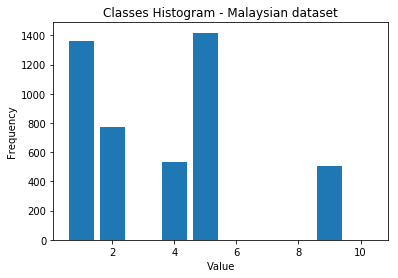

freq->
 [1362  769  532 1418  503]
Mean: 916.80
 Var: 158110.16
 Max: 1418.00
 Min: 503.00
 Sum: 4584.00
 STD: 397.63
 CV: 0.43

Total number of objects: 4584


In [80]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

file_p = 'results{}/gt_phase_1.txt'.format(experiment)

#file_p = '/home/hossam/PycharmProjects/tsr-py-faster-rcnn/data/GTSDB/Annotations/gt.txt'

file = open(file_p,'rt')


tmp = []
for line in file:
    tmp.append( int(line.split(';')[5].replace('\r\n',''))+1)
#plt.hist(x, normed=True, bins=30)
# hist, bins = np.histogram(tmp, bins=66)
# width = 0.7 * (bins[1] - bins[0])
# center = (bins[:-1] + bins[1:]) / 2
# plt.bar(center, hist, align='center', width=width)
# plt.legend()
# plt.show()

plt.hist(tmp,histtype='bar', rwidth=0.8,bins=range(1,num_cls+3,1), align='left')
###plt.hist(tmp,histtype='bar', rwidth=0.8,bins=range(1,50,1), align='left')
plt.title("Classes Histogram - Malaysian dataset")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.show()

#print tmp
file.close()
a = np.array(tmp)
unique, counts = np.unique(a, return_counts=True)

frq = np.array(counts)
print ('freq->\n',counts)
#print keep
#print classes[keep]
#print a.mean(), a.var(), a.max(), a.min(), a.sum(), a.std()
print ('Mean: {:.2f}\n'.format(frq.mean()),\
    'Var: {:.2f}\n'.format(frq.var()),\
    'Max: {:.2f}\n'.format(frq.max()),\
    'Min: {:.2f}\n'.format(frq.min()),\
    'Sum: {:.2f}\n'.format(frq.sum()),\
    'STD: {:.2f}\n'.format(frq.std()),\
    'CV: {:.2f}\n'.format(frq.std()/frq.mean()) )
print ('Total number of objects:',len(tmp))

In [81]:
!cat data/MTSD/Annotations/gt_reduced.txt > ./results4/gt_phase_1_after_aug.txt
!cat ./results4/gt_phase_1.txt >> ./results4/gt_phase_1_after_aug.txt

## Phase 2

## 1) Calculate the freq of each class and store all the freq < 50 in keep varaibale array

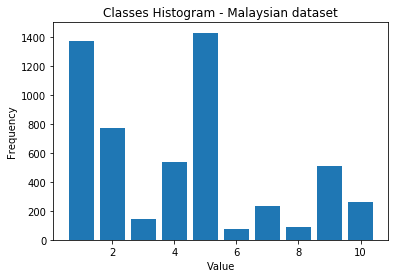

freq->
 [1373  775  144  536 1430   72  235   87  507  264]
Mean: 542.30
 Var: 229251.61
 Max: 1430.00
 Min: 72.00
 Sum: 5423.00
 STD: 478.80
 CV: 0.88

Total number of objects: 5423


In [83]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

file_p = 'results{}/gt_phase_1_after_aug.txt'.format(experiment)

#file_p = '/home/hossam/PycharmProjects/tsr-py-faster-rcnn/data/GTSDB/Annotations/gt.txt'

file = open(file_p,'rt')


tmp = []
for line in file:
    tmp.append( int(line.split(';')[5].replace('\r\n',''))+1)
#plt.hist(x, normed=True, bins=30)
# hist, bins = np.histogram(tmp, bins=66)
# width = 0.7 * (bins[1] - bins[0])
# center = (bins[:-1] + bins[1:]) / 2
# plt.bar(center, hist, align='center', width=width)
# plt.legend()
# plt.show()

plt.hist(tmp,histtype='bar', rwidth=0.8,bins=range(1,num_cls+3,1), align='left')
###plt.hist(tmp,histtype='bar', rwidth=0.8,bins=range(1,50,1), align='left')
plt.title("Classes Histogram - Malaysian dataset")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.show()

#print tmp
file.close()
a = np.array(tmp)
unique, counts = np.unique(a, return_counts=True)

frq = np.array(counts)
print ('freq->\n',counts)
#print keep
#print classes[keep]
#print a.mean(), a.var(), a.max(), a.min(), a.sum(), a.std()
print ('Mean: {:.2f}\n'.format(frq.mean()),\
    'Var: {:.2f}\n'.format(frq.var()),\
    'Max: {:.2f}\n'.format(frq.max()),\
    'Min: {:.2f}\n'.format(frq.min()),\
    'Sum: {:.2f}\n'.format(frq.sum()),\
    'STD: {:.2f}\n'.format(frq.std()),\
    'CV: {:.2f}\n'.format(frq.std()/frq.mean()) )
print ('Total number of objects:',len(tmp) )

In [102]:
classes[5]

'caution-hump'

In [84]:
keep = np.where(frq < 50)
print(keep)

(array([], dtype=int64),)


## 2) Loop for each image
### - blur the objects that is not in keep array
### - store only the images that have at least one object in keep array in aug folder
### - store aswell the labels for each image obj in aug folder in aug_labels

In [86]:
#im_path = './data/MTSD/Images/'
files = [f for f in os.listdir(im_path) if os.path.isfile(os.path.join(im_path,f))]
#mask_path = './data/test/gt/'
#label_path = './data/test4/labels/'

#fname = 'P1840185.JPG'
#fname = 'P1840114.JPG'
#fname = 'P1840116.JPG'
#fname = 'P1860061.JPG'

#keep = [0,2,3,4,5,6,8,9,10,11]
for fname in files:
    if fname.split('.')[1] == 'txt':
        continue
        
    if not os.path.isfile(os.path.join(label_path, fname.split('.')[0]+'.txt')):
        #fault = open('faults.txt', 'a')
        #fault.write(fil+'\n')
        continue
    
    store = False

    im = cv2.imread(os.path.join(im_path, fname))
    org = im.copy()
    f = open(os.path.join(label_path, fname.split('.')[0]+'.txt'), 'r')
    
    lines = f.readlines()
    text = ''
    for line in lines:
        spl = line.split(' ')
        i = np.where(classes == spl[0])[0][0]
        if i not in keep[0]:
            x1 = int(spl[1])#+1
            y1 = int(spl[2])#+1
            x2 = int(spl[3])#-1
            y2 = int(spl[4])#-1

            #print y2-y1, x2-x1

            #cv2.imwrite('without_aug.jpg', im)
            #print im[y1:y2,x1:x2]

            np.random.shuffle(im[y1:y2+1,x1:x2+1,0])
            np.random.shuffle(im[y1:y2+1,x1:x2+1,0].T)

            np.random.shuffle(im[y1:y2+1,x1:x2+1,1])
            np.random.shuffle(im[y1:y2+1,x1:x2+1,1].T)

            np.random.shuffle(im[y1:y2+1,x1:x2+1,2])
            np.random.shuffle(im[y1:y2+1,x1:x2+1,2].T)

            #np.random.shuffle(im[y1:y2,x1:x2])
            #np.random.shuffle(im[y1:y2,x1:x2].T)

            blur = cv2.blur(im, (50, 50))

            #print lines[0] , x1, x2, y1, y2

            #print im[y1:y2,x1:x2,0]
            #cv2.imwrite('aug.jpg', im)

            num =10
            im[y1-num:y2+num,x1-num:x2+num] = blur[y1-num:y2+num,x1-num:x2+num]
            #cv2.imwrite('aug_blur.jpg', im)

    for line in lines:
        spl = line.split(' ')
        i = np.where(classes == spl[0])[0][0]
        if i in keep[0]:
            store = True
            
            #spl = line.split(' ')
            x1 = int(spl[1])#+1
            y1 = int(spl[2])#+1
            x2 = int(spl[3])#-1
            y2 = int(spl[4])#-1
            text += line
            #im2 = cv2.imread(os.path.join(im_path, fname))
            ynum = int(y2-y1)/14
            xnum = int(x2-x1)/14
            im[y1-ynum:y2+ynum,x1-xnum:x2+xnum] = org[y1-ynum:y2+ynum,x1-xnum:x2+xnum]
    
    if store:
        cv2.imwrite(os.path.join(aug2_path,fname.split('.')[0]+'_aug'+'.jpg'), im)
        f_out = open(os.path.join(aug2_labels_path, fname.split('.')[0]+'_aug'+'.txt'), 'w')
        f_out.write(text)
        f_out.close()

## 3) Generate the mask image for each aug image

In [140]:
#im_path = './data/test4/aug2/'
files = [f for f in os.listdir(aug2_path) if os.path.isfile(os.path.join(aug2_path,f))]

OSError: [Errno 2] No such file or directory: './data/test4/aug2/'

In [411]:
#mask_path = './data/test3/aug2_gt/'
#label_path = './data/test3/aug2_labels/'

for fil in files:
    if not os.path.isfile(os.path.join(aug2_labels_path, fil.split('.')[0]+'.txt')):
        #fault = open('faults.txt', 'a')
        #fault.write(fil+'\n')
        continue
    im = cv2.imread(os.path.join(aug2_path, fil))
    f = open(os.path.join(aug2_labels_path, fil.split('.')[0]+'.txt'))
    #print os.path.join(label_path, fil.split('.')[0]+'.txt')
    lines = f.readlines()
    im_out = np.zeros(im.shape, np.uint8)
    for i, line in enumerate(lines):
        spl = line.split(' ')
        x1 = int(spl[1])#+1
        y1 = int(spl[2])#+1
        x2 = int(spl[3])#-1
        y2 = int(spl[4])#-1
        #print fil, i, line
        cv2.rectangle(im_out, (x1,y1), (x2,y2),color_list[i], -1)
    #print '______'
    cv2.imwrite(os.path.join(aug2_gt_path, fil), im_out)

## 4) Augment the images with ground truth mask

In [412]:
import Augmentor

p = Augmentor.Pipeline(aug2_path)
p.ground_truth(aug2_gt_path)

#p.rotate(probability=0.4, max_left_rotation=5, max_right_rotation=5)
#p.zoom(probability=0.3, min_factor=1.05, max_factor=1.1)
#p.random_distortion(probability=0.7, grid_width=2, grid_height=2, magnitude=5)
#p.skew_tilt(probability=0.5, magnitude=0.2)
#p.skew(probability=0.5, magnitude=0.2)

p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
p.zoom(probability=0.5, min_factor=1.1, max_factor=1.2)
p.random_distortion(probability=0.7, grid_width=4, grid_height=4, magnitude=8)
p.skew_tilt(probability=0.5, magnitude=0.3)
p.skew(probability=0.5, magnitude=0.3)

#p.sample(44*100, multi_threaded=True)
p.sample(395*10, multi_threaded=True)

Executing Pipeline:   0%|          | 0/3950 [00:00<?, ? Samples/s]

Initialised with 33 image(s) found.
Output directory set to ./data/test3/aug2/output.33 ground truth image(s) found.


Processing <PIL.Image.Image image mode=RGB size=4592x3448 at 0x7F9AAC676490>: 100%|██████████| 3950/3950 [23:32<00:00,  2.80 Samples/s]                    


In [413]:
#aug_path = './data/test3/aug2/output/'
files = [f for f in os.listdir(aug_path) if os.path.isfile(os.path.join(aug2_output_path,f))]

gts = []
augs = []

for fi in files:
    if 'original' in fi:
        augs.append(fi)
    else:
        gts.append(fi)

In [414]:
print (gts[0].split('_')[6] in augs[0].split('_')[4])
print (gts[0])
print (augs[0])
x = 'aug_original_49_aug.jpg_45daa9b6-92a4-4fc2-893e-f08ac42f23d1.jpg'
y = x.replace('aug_original_', '_groundtruth_(1)_aug_')
print (y, os.path.isfile(os.path.join(aug2_output_path, y)))
print (len(augs), len(gts))

print (aug2_labels_path, aug2_gt_path)

False
_groundtruth_(1)_aug2_56_2015_aug.jpg_4ae5a185-c51c-412b-911e-849ccfc5dac3.jpg
aug2_original_P1840069_aug.jpg_7d576e61-9eac-4651-bd18-f4fdfd9091ad.jpg
_groundtruth_(1)_aug_49_aug.jpg_45daa9b6-92a4-4fc2-893e-f08ac42f23d1.jpg False
3950 3950
./data/test3/aug2_labels/ ./data/test3/aug2_gt/


## 5) Create the annotation for the new augmented images

In [415]:
# mask with different colors space per each object sequential

#./data/test/gt/P1840014.JPG
#./data/test/gt/P1840114.JPG
# P1860079.JPG

#ff = '130.jpg'
#mask_gt_path = './data/test3/aug2/output/'
#label_path = './data/test3/aug2_labels/'

f_out = open('results{}/gt_phase_2.txt'.format(experiment), 'w')
for aug in augs:
    aug_sp = aug.split('_')
    gt = aug.replace('aug2_original_', '_groundtruth_(1)_aug2_')
    ############## bug fix if org file name have '_' #############
    org_file =  aug_sp[2] #+'_'+aug_sp[3]
    i=3
    while('aug' not in aug_sp[i]):
        org_file = org_file + '_' + aug_sp[i]
        i=i+1
    org_file = org_file + '_' + aug_sp[i]
    ##############################################################
    
    
    if not os.path.exists(os.path.join(aug2_labels_path, org_file.split('.')[0]+'.txt')):
        continue
        
    im = cv2.imread(os.path.join(aug2_output_path,gt))
    f = open(os.path.join(aug2_labels_path, org_file.split('.')[0]+'.txt'), 'r')
    
    #im[im == 255] = 1
    #im[im == 0] = 255
    #im[im == 1] = 0
    lines = f.readlines()
    #print 'Number of objects', len(lines)
    for i in range(0, len(lines)):
        lower = np.array(color_list[i])-10
        upper = np.array(color_list[i])+10
        mask = cv2.inRange(im, lower, upper)
        im3 = cv2.bitwise_and(im, im, mask=mask)


        #print 'obj#', i
        im2 = cv2.cvtColor(im3, cv2.COLOR_BGR2GRAY)

        #print np.max(im2), np.min(im2)

        #cv2.imwrite(org_file+str(i)+'_thr.jpg', im2)
        ret, thresh = cv2.threshold(im2, 0, np.max(im2)+1 ,cv2.THRESH_BINARY)
        _, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        #print len(contours), org_file
        if len(contours) == 0:
            continue
        #for i in range(0, len(contours)):
            #if(i%2 == 0)

        # getting the maximum width contours
        x,y,w,h = cv2.boundingRect(contours[0])
        for cnt in contours:
            cx, cy, cw, ch = cv2.boundingRect(cnt)
            if cw*ch > w*h: # bug fix compare the area instead of the width only
                x,y,w,h = cx, cy, cw, ch
        #cnt = contours[i]
        #if x == 0 or y == 0 or ((x+w) == im.shape[1]) or ((y+h) == im.shape[0]):
            #nw = float(w)/im.shape[1]
            #nh = float(h)/im.shape[0]
            #ratio = float(max(nw,nh)) / min(nw,nh)
            #if ratio >= 2.5:
                #print('skip->', ratio,nw, nh, aug, x, y, w, h, 'cls',cls_num)
                #continue
        #cv2.rectangle(im, (x,y), (x+w, y+h), (0,240,180), 5)
        cls_num = np.where(classes == lines[i].split(' ')[0])[0][0]
        f_out.write('./output/'+aug+';'+str(x)+';'+str(y)+';'+str(x+w)+';'+str(y+h)+';'+ str(cls_num) +'\n')
        #print (x,y), (x+w, y+h)
        #cv2.imwrite(org_file+str(i)+'.jpg', im)

        #print '_______'
f_out.close()

## filter all corner bbox

In [416]:
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

#mask_gt_path = './data/test3/aug2/output/'
#label_path = './data/test3/aug2_labels/'
f_anno = open('results{}/gt_phase_2.txt'.format(experiment), 'r')
lines = f_anno.readlines()

outlayer = []
outlayer_index = []

for i, line in enumerate(lines):
        spl = line.split(';')
        fname = spl[0]
        x1 = int(spl[1])#+1
        y1 = int(spl[2])#+1
        x2 = int(spl[3])#-1
        y2 = int(spl[4])#-1
        
        f_fname = os.path.join(aug2_path,fname)
        img = Image.open(f_fname)
        #img=mpimg.imread(f_fname)
        #if (x1 == 0) or (x2 == img.shape[1]) or (y1 == 0) or (y2 == img.shape[0]):
        if (x1 == 0) or (x2 == img.width) or (y1 == 0) or (y2 == img.height):
            #print(img.height, img.width)
            #print(f_fname, x1,y1,x2,y2)
            outlayer.append( (f_fname, x1,y1,x2,y2) )
            outlayer_index.append(i)
f_anno.close()

In [417]:
print(len(outlayer))

213


In [418]:
%matplotlib inline
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual#, Button
import ipywidgets as widgets
from IPython import display

import matplotlib.patches as patches

keeping = []
discarding = []

i=0
button_yes = widgets.Button(description="Keep")
button_no = widgets.Button(description="Discard")

print(i+1,'/',len(outlayer))
display.display(button_yes,button_no)
#display.display(button_no)
fig,ax = plt.subplots(1, figsize = (20,10))
ax.imshow(Image.open(outlayer[i][0]))
rect = patches.Rectangle((outlayer[i][1],outlayer[i][2]),outlayer[i][3]-outlayer[i][1],outlayer[i][4]-outlayer[i][2],linewidth=3,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

def on_click_yes(b):
    #print("yes")
    global i
    
    keeping.append(i)
    i=i+1
    
    display.clear_output()
    if i>= len(outlayer):
        print("Finish")
        return
    
    print(i+1,'/',len(outlayer))
    display.display(button_yes)
    display.display(button_no)
    fig,ax = plt.subplots(1, figsize = (20,10))
    ax.imshow(Image.open(outlayer[i][0]))
    rect = patches.Rectangle((outlayer[i][1],outlayer[i][2]),outlayer[i][3]-outlayer[i][1],outlayer[i][4]-outlayer[i][2],linewidth=3,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()
    
def on_click_no(b):
    global i
    
    discarding.append(i)
    i=i+1
    
    display.clear_output()
    if i>= len(outlayer):
        print("Finish")
        return
    
    
    print(i+1,'/',len(outlayer))
    display.display(button_yes)
    display.display(button_no)
    fig,ax = plt.subplots(1, figsize = (20,10))
    ax.imshow(Image.open(outlayer[i][0]))
    rect = patches.Rectangle((outlayer[i][1],outlayer[i][2]),outlayer[i][3]-outlayer[i][1],outlayer[i][4]-outlayer[i][2],linewidth=3,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

    
button_yes.on_click(on_click_yes)
button_no.on_click(on_click_no)

Finish


In [419]:
print('keeping:',len(keeping),'/',len(outlayer),'\ndiscarding:', len(discarding),'/', len(outlayer))

keeping: 87 / 213 
discarding: 126 / 213


In [420]:
noutlayer = np.array(outlayer)
noutlayer_index = np.array(outlayer_index)
new_lines = []
mapping_lines = {}
for ii,jj in enumerate(noutlayer_index):
    mapping_lines[jj] = ii
    #print(ii, jj, lines[jj])
for ii, line in enumerate(lines):
    if mapping_lines.has_key(ii):
        if mapping_lines[ii] in discarding:
            continue
    new_lines.append(line)
#print(keeping)
#print(noutlayer[keeping])

In [421]:
print(len(new_lines), len(lines))

3880 4006


In [422]:
!cp ./results4/gt_phase_2.txt ./results4/gt_phase_2.txt.backup

In [423]:
f_out = open('results{}/gt_phase_2.txt'.format(experiment), 'w')
f_out.writelines(new_lines)
f_out.close()

In [424]:
print(discarding)
print(noutlayer[discarding])

[0, 2, 3, 7, 8, 10, 11, 12, 14, 15, 16, 18, 19, 20, 22, 23, 25, 29, 34, 35, 37, 40, 41, 42, 45, 47, 48, 49, 51, 52, 53, 54, 55, 57, 63, 64, 65, 66, 67, 68, 71, 78, 79, 80, 81, 82, 83, 84, 88, 91, 92, 96, 98, 101, 104, 106, 107, 109, 110, 111, 112, 113, 115, 116, 118, 119, 120, 121, 123, 126, 128, 130, 131, 132, 133, 134, 135, 136, 139, 140, 141, 142, 149, 150, 152, 153, 156, 157, 158, 160, 162, 163, 164, 166, 168, 169, 173, 174, 175, 176, 177, 178, 180, 182, 184, 185, 186, 188, 189, 190, 191, 192, 195, 196, 197, 200, 202, 203, 204, 205, 206, 207, 208, 209, 211, 212]
[['./data/test3/aug2/./output/aug2_original_P1840289_aug.jpg_8310e36e-8ea6-43f3-b28e-9c1f5d6ab480.jpg'
  '2700' '0' '3371' '490']
 ['./data/test3/aug2/./output/aug2_original_P1860056_aug.jpg_8174d7c0-1d28-4279-901b-43be1116ff5d.jpg'
  '4225' '1059' '4592' '1635']
 ['./data/test3/aug2/./output/aug2_original_P1840560_aug.jpg_385beb07-7ab6-4af3-9a98-bfffb516a4f8.jpg'
  '0' '1531' '277' '1853']
 ['./data/test3/aug2/./output/aug

## Check histogram for phase 2 images

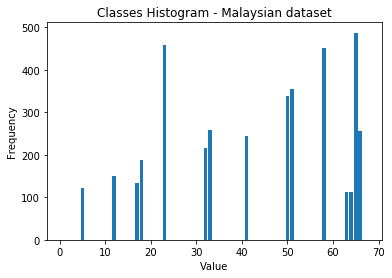

freq->
 [121 151 134 188 458 217 258 244 337 354 452 112 112 487 255]
Mean: 258.67
 Var: 16035.96
 Max: 487.00
 Min: 112.00
 Sum: 3880.00
 STD: 126.63
 CV: 0.49

Total number of objects: 3880


In [425]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

file_p = 'results{}/gt_phase_2.txt'.format(experiment)

#file_p = '/home/hossam/PycharmProjects/tsr-py-faster-rcnn/data/GTSDB/Annotations/gt.txt'

file = open(file_p,'rt')


tmp = []
for line in file:
    tmp.append( int(line.split(';')[5].replace('\r\n',''))+1)
#plt.hist(x, normed=True, bins=30)
# hist, bins = np.histogram(tmp, bins=66)
# width = 0.7 * (bins[1] - bins[0])
# center = (bins[:-1] + bins[1:]) / 2
# plt.bar(center, hist, align='center', width=width)
# plt.legend()
# plt.show()

plt.hist(tmp,histtype='bar', rwidth=0.8,bins=range(1,num_cls+3,1), align='left')
###plt.hist(tmp,histtype='bar', rwidth=0.8,bins=range(1,50,1), align='left')
plt.title("Classes Histogram - Malaysian dataset")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.show()

#print tmp
file.close()
a = np.array(tmp)
unique, counts = np.unique(a, return_counts=True)

frq = np.array(counts)
print ('freq->\n',counts)
#print keep
#print classes[keep]
#print a.mean(), a.var(), a.max(), a.min(), a.sum(), a.std()
print ('Mean: {:.2f}\n'.format(frq.mean()),\
    'Var: {:.2f}\n'.format(frq.var()),\
    'Max: {:.2f}\n'.format(frq.max()),\
    'Min: {:.2f}\n'.format(frq.min()),\
    'Sum: {:.2f}\n'.format(frq.sum()),\
    'STD: {:.2f}\n'.format(frq.std()),\
    'CV: {:.2f}\n'.format(frq.std()/frq.mean()) )
print ('Total number of objects:',len(tmp))

In [426]:
!cat ./data/MTSD/Annotations/gt_reduced.txt > ./results4/gt_phase_2_after_aug.txt
!cat ./results4/gt_phase_2.txt >> ./results4/gt_phase_2_after_aug.txt

!cat ./results4/gt_phase_1_after_aug.txt > ./results4/gt_phase_1_2_after_aug.txt
!cat ./results4/gt_phase_2.txt >> ./results4/gt_phase_1_2_after_aug.txt

## Check histogram for phase 2 images merged with original images

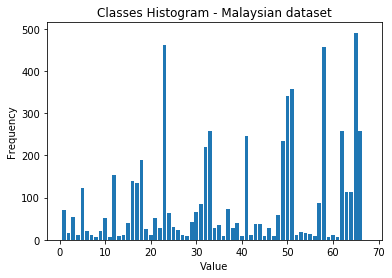

freq->
 [ 70  17  54  11 122  20  11   6  20  51   6 153   9  12  39 140 135 190
  25  12  52  27 462  63  30  24  12   8  42  66  85 219 259  27  34   9
  72  28  41   8 246  11  37  37   9  27   8  59 234 340 357  11  18  15
  13   8  87 456   6  11   6 257 113 113 491 257]
Mean: 89.36
 Var: 14256.60
 Max: 491.00
 Min: 6.00
 Sum: 5898.00
 STD: 119.40
 CV: 1.34

Total number of objects: 5898


In [427]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

file_p = 'results{}/gt_phase_2_after_aug.txt'.format(experiment)

#file_p = '/home/hossam/PycharmProjects/tsr-py-faster-rcnn/data/GTSDB/Annotations/gt.txt'

file = open(file_p,'rt')


tmp = []
for line in file:
    tmp.append( int(line.split(';')[5].replace('\r\n',''))+1)
#plt.hist(x, normed=True, bins=30)
# hist, bins = np.histogram(tmp, bins=66)
# width = 0.7 * (bins[1] - bins[0])
# center = (bins[:-1] + bins[1:]) / 2
# plt.bar(center, hist, align='center', width=width)
# plt.legend()
# plt.show()

plt.hist(tmp,histtype='bar', rwidth=0.8,bins=range(1,num_cls+3,1), align='left')
###plt.hist(tmp,histtype='bar', rwidth=0.8,bins=range(1,50,1), align='left')
plt.title("Classes Histogram - Malaysian dataset")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.show()

#print tmp
file.close()
a = np.array(tmp)
unique, counts = np.unique(a, return_counts=True)

frq = np.array(counts)
print ('freq->\n',counts)
#print keep
#print classes[keep]
#print a.mean(), a.var(), a.max(), a.min(), a.sum(), a.std()
print ('Mean: {:.2f}\n'.format(frq.mean()),\
    'Var: {:.2f}\n'.format(frq.var()),\
    'Max: {:.2f}\n'.format(frq.max()),\
    'Min: {:.2f}\n'.format(frq.min()),\
    'Sum: {:.2f}\n'.format(frq.sum()),\
    'STD: {:.2f}\n'.format(frq.std()),\
    'CV: {:.2f}\n'.format(frq.std()/frq.mean()))
print ('Total number of objects:',len(tmp))

## Check histogram for phase 2 images merged with phase 1 and the original Image

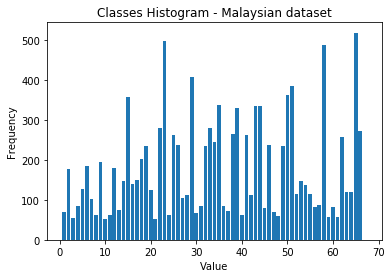

freq->
 [ 70 178  54  85 127 186 103  61 194  51  61 179  75 147 359 140 149 203
 234 126  52 281 499  63 263 238 106 113 407  66  85 235 280 245 338  84
  72 264 330  63 263 113 336 336  79 238  70  59 234 362 385 115 147 137
 115  83  87 489  56  82  57 257 121 121 519 273]
Mean: 181.82
 Var: 14634.21
 Max: 519.00
 Min: 51.00
 Sum: 12000.00
 STD: 120.97
 CV: 0.67

Total number of objects: 12000


In [428]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

file_p = 'results{}/gt_phase_1_2_after_aug.txt'.format(experiment)

#file_p = '/home/hossam/PycharmProjects/tsr-py-faster-rcnn/data/GTSDB/Annotations/gt.txt'

file = open(file_p,'rt')


tmp = []
for line in file:
    tmp.append( int(line.split(';')[5].replace('\r\n',''))+1)
#plt.hist(x, normed=True, bins=30)
# hist, bins = np.histogram(tmp, bins=66)
# width = 0.7 * (bins[1] - bins[0])
# center = (bins[:-1] + bins[1:]) / 2
# plt.bar(center, hist, align='center', width=width)
# plt.legend()
# plt.show()

plt.hist(tmp,histtype='bar', rwidth=0.8,bins=range(1,num_cls+3,1), align='left')
###plt.hist(tmp,histtype='bar', rwidth=0.8,bins=range(1,50,1), align='left')
plt.title("Classes Histogram - Malaysian dataset")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.show()

#print tmp
file.close()
a = np.array(tmp)
unique, counts = np.unique(a, return_counts=True)

frq = np.array(counts)
print ('freq->\n',counts)
#print keep
#print classes[keep]
#print a.mean(), a.var(), a.max(), a.min(), a.sum(), a.std()
print ('Mean: {:.2f}\n'.format(frq.mean()),\
    'Var: {:.2f}\n'.format(frq.var()),\
    'Max: {:.2f}\n'.format(frq.max()),\
    'Min: {:.2f}\n'.format(frq.min()),\
    'Sum: {:.2f}\n'.format(frq.sum()),\
    'STD: {:.2f}\n'.format(frq.std()),\
    'CV: {:.2f}\n'.format(frq.std()/frq.mean()))
print ('Total number of objects:',len(tmp))

# Elimination
1- All images are in All_images withound the mask image

2- all the annotation are in gt_phase_1_2_after_aug.txt

what i have to do:

1- Collect the total frequancy for each object

2- Generate for each image a dictienary to all objects in the image

3- from 1 & 2 check loop for each **class out of 66** image check if freq > 50 

    if True:
        loop for all images
            check if we delete the image no other object freq in the image will not be less 50:
                if yes -> delete the whole image and its annotation from the groundtruth then update the freq array
                if no -> then hide the objects that will not be affected then update the annotation as well as the freq array
                

In [94]:
!ln -s /home/dgxadmin/DL/Datasets/MTSD/Images/*.jpg ./data/All_images4/
!ln -s /home/dgxadmin/DL/Datasets/MTSD/Images/*.JPG ./data/All_images4/
!ln -s /home/dgxadmin/DL/mtsd_augmentation/data/test4/aug/output/aug_* ./data/All_images4/
#!ln -s /home/dgxadmin/DL/mtsd_augmentation/data/test4/aug2/output/aug2_* ./data/All_images4/

In [95]:
def anno_parse(line):
    spl = line.split(';')
    name = spl[0]
    x1 = spl[1]
    y1 = spl[2]
    x2 = spl[3]
    y2 = spl[4]
    cls = spl[5].strip()
    name = name.replace('./output/','')
    return name, int(x1), int(y1), int(x2), int(y2), int(cls)

In [96]:
import numpy as np
import os
import cv2
import time
#import progressbar

images_path = 'data/All_images{}'.format(experiment)
gt_path = 'results{}/gt_phase_1_after_aug.txt'.format(experiment)

f = open(gt_path, 'rt')

# 1- Collect the total frequancy for each object
tmp = []
for line in f:
    tmp.append( int(line.split(';')[5].replace('\r\n',''))+1)
    
a = np.array(tmp)
unique, counts = np.unique(a, return_counts=True)

frq = np.array(counts)
print (frq, len(frq))

# 2- Generate for each image a dictienary to all objects in the image
my_dict = {}
f.seek(0)
lines = f.readlines()
#with progressbar.ProgressBar(maxval=len(lines)) as bar:
for i, line in enumerate(lines):
    name, x1,y1,x2,y2,cls = anno_parse(line)
    if not my_dict.has_key(name):
        my_dict.update({name:[]})

    my_obj = (x1,y1, x2, y2, cls)
    my_dict[name].append(my_obj)

        #bar.update(i)
print ('Done...')

# eliminate the objects with bbox aspect different very high or small
# and in corner
#for img in my_dict:
    #print img[-20::], my_dict[img]
#    for obj in my_dict[img]:
#        x1,y1,x2,y2,_ = obj
#        if x1 == 0:
#            print img
    

f.close()

[1373  775  144  536 1430   72  235   87  507  264] 10
Done...


In [98]:
from PIL import Image

i = 0
for img in my_dict:
    for obj in my_dict[img]:
        im = Image.open(os.path.join(images_path,img))
        w,h = im.size
        x1,y1,x2,y2,cls = obj
        if x1 == 0 or x2 == w or y1 == 0 or y2 == h:
            i+=1
            print (img, classes[cls], x1,y1,x2,y2)
            
print (i)

aug_original_P1840598_aug.jpg_5db7849b-efa5-4288-935e-71de1eb4e5e2.jpg no-entry-for-vehicles-ex-5T-truntks-etc 0 602 117 866
aug_original_P1840485_aug.jpg_de549e0f-f841-430b-9885-c55c415913bd.jpg minor-road-on-left-opt2 0 1412 419 1837
aug_original_P1840139_aug.jpg_2d199649-2bd7-4060-aeb4-29ea172f7cd6.jpg no-entry-for-vehicles-ex-5T-truntks-etc 2325 0 3027 695
aug_original_P1840138_aug.jpg_c72ad80c-80e3-4bcf-afab-0928ac5bd84d.jpg no-entry-for-vehicles-ex-5T-truntks-etc 0 1055 117 1375
aug_original_P1840470_aug.jpg_4cef0de8-f781-495f-8c85-4505e6642d6f.jpg no-left-turn 4198 633 4592 1153
aug_original_P1840470_aug.jpg_0a9258da-bea7-4de3-abcc-480bd91d0d18.jpg no-left-turn 4443 994 4592 1500
aug_original_P1840139_aug.jpg_9b06c968-49ad-4620-97b9-9d6dd98f4e8e.jpg no-entry-for-vehicles-ex-5T-truntks-etc 3131 0 3705 775
aug_original_P1840470_aug.jpg_4d6f1ea3-8c49-42bb-b050-f57d2b477ce4.jpg no-left-turn 4330 949 4592 1439
aug_original_P1840002_aug.jpg_7f1d2a2f-239f-458e-9d05-9fd9faebcba2.jpg no-

aug_original_P1840138_aug.jpg_75c14621-1b3f-466c-b27c-9756bcb70f36.jpg no-entry-for-vehicles-ex-5T-truntks-etc 0 340 189 735
aug_original_P1840138_aug.jpg_6f796b8d-923b-4a44-b66b-d53fc8ef07d0.jpg no-entry-for-vehicles-ex-5T-truntks-etc 0 893 83 1196
aug_original_P1840598_aug.jpg_074f4074-6762-4342-8c77-da2ff44cf239.jpg no-entry-for-vehicles-ex-5T-truntks-etc 0 703 141 1026
aug_original_P1840002_aug.jpg_6409cb66-2817-4d21-ab12-ce338290a336.jpg no-left-turn 0 1329 149 1557
aug_original_P1840138_aug.jpg_50de949a-257a-4768-9670-a407faad6474.jpg no-entry-for-vehicles-ex-5T-truntks-etc 0 950 101 1259
aug_original_P1840470_aug.jpg_b2143dd5-ae3a-4efb-bde0-e50d13e66cec.jpg no-left-turn 3979 423 4592 1059
aug_original_P1840598_aug.jpg_fd65276c-c747-4608-ae11-f0f148e3d964.jpg no-entry-for-vehicles-ex-5T-truntks-etc 0 809 25 960
aug_original_P1840598_aug.jpg_e29574da-fd81-4731-90c4-f8cb3330eb32.jpg no-entry-for-vehicles-ex-5T-truntks-etc 0 583 295 943
aug_original_P1860092_aug.jpg_595725a9-3a60-43

aug_original_P1840002_aug.jpg_c6715abe-77f8-443f-82a9-8066c0ca3e7c.jpg no-left-turn 0 1627 257 1892
aug_original_P1840138_aug.jpg_c37d9f4b-f5b3-44a1-8166-fe6475a8dc7b.jpg no-entry-for-vehicles-ex-5T-truntks-etc 0 1053 91 1374
aug_original_P1840470_aug.jpg_d4af9cf6-4d26-41a3-8bbf-bc8f7152e3c3.jpg no-left-turn 4282 586 4592 1141
aug_original_P1840470_aug.jpg_4d9e952c-c9be-4071-8b2e-7cc12001a765.jpg no-left-turn 4223 806 4592 1289
aug_original_P1840139_aug.jpg_9129e7ef-d0cc-44bb-a086-8f7ef5a80c8f.jpg no-entry-for-vehicles-ex-5T-truntks-etc 2846 0 3517 729
aug_original_P1840138_aug.jpg_64cc2bdc-99e8-4dfd-89aa-dcbd86bd7193.jpg no-entry-for-vehicles-ex-5T-truntks-etc 0 748 201 1185
aug_original_P1840598_aug.jpg_622e6432-9fd9-4e29-9aac-391e6f990970.jpg no-entry-for-vehicles-ex-5T-truntks-etc 0 735 149 997
aug_original_P1840002_aug.jpg_5a59b402-cb65-4fc2-987e-c5bc5980d544.jpg no-left-turn 0 1529 101 1765
aug_original_P1840138_aug.jpg_13d4aa63-185a-435f-9714-ac6e6dfcb864.jpg no-entry-for-vehicl

aug_original_P1840138_aug.jpg_558573dc-19d0-42b9-9b2c-359f25c090cc.jpg no-entry-for-vehicles-ex-5T-truntks-etc 0 1103 40 1435
aug_original_P1840138_aug.jpg_3a369aac-8816-4def-870b-fd7b26e6877b.jpg no-entry-for-vehicles-ex-5T-truntks-etc 0 1063 91 1371
aug_original_P1840138_aug.jpg_4bae3a4e-4196-4c13-8950-67f7683bbf4e.jpg no-entry-for-vehicles-ex-5T-truntks-etc 0 840 69 1113
aug_original_P1840138_aug.jpg_6936a0e6-a3ea-48e5-ac5e-cb2e6728f45f.jpg no-entry-for-vehicles-ex-5T-truntks-etc 0 648 3 657
aug_original_P1840138_aug.jpg_e3fe7a2f-99b3-464f-a19f-6e2b837255a1.jpg no-entry-for-vehicles-ex-5T-truntks-etc 0 995 73 1298
aug_original_P1840138_aug.jpg_bb1c997e-cb75-416b-9210-0dc0c968252b.jpg no-entry-for-vehicles-ex-5T-truntks-etc 0 674 250 1019
aug_original_P1840598_aug.jpg_a613d07a-3599-493b-9d73-c9633373b7a6.jpg no-entry-for-vehicles-ex-5T-truntks-etc 0 805 143 1201
aug_original_P1840002_aug.jpg_48611b45-0992-4f92-9a81-b45676aba710.jpg no-left-turn 0 1279 238 1488
aug_original_P1840598_a

3- from 1 & 2 check loop for each class out of 66 image check if freq > 50

if True:

    loop for all images
    
        check if we delete the image no other object freq in the image will not be less 50:
        
            if yes -> delete the whole image and its annotation from the groundtruth then update the freq array
            
            if no -> then hide the objects that will not be affected then update the annotation as well as the freq array


In [99]:
images_path = 'data/All_images{}'.format(experiment)
del_image_path = 'del_image{}.txt'.format(experiment)
del_object_path = 'del_object{}.txt'.format(experiment)

del_image = open(del_image_path, 'wt')
del_object = open(del_object_path, 'wt')

imgs_del = [] # loop to delete all img from my_dict

for img in my_dict:
    im_del = True
    objs_del = []
    objs_not_del = []
    # check delete the image or not
    for i, obj in enumerate(my_dict[img]):
        _,_,_,_,cls = obj
        if frq[cls] <= 50:
            im_del = False
            objs_not_del.append(obj)
        else:
            frq[cls] -= 1 # correct here because we may have two objects from the same class and in case of im_del all
                            # of the object freq will be subtracted by 1 
            objs_del.append(obj)
            
    if im_del == True:
        #print img
        del_image.write(img+' '+str(objs_del)+'\n\r')
        os.remove(os.path.join(images_path, img))
        #del my_dict[img] #####->>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>. del will affect the loop
        imgs_del.append(img) # TO NOT EFFECT THE LOOP I WILL DELETE THEM FROM my_dict AFTER THE LOOP
    else:
        #if len(objs_del) == 0: # comment this if i want to remove all the link files and copy the image
        #    continue           # -------------------- it will take time ------------------------------
        tmp = cv2.imread(os.path.join(images_path,img))
        org = tmp.copy()
        os.remove(os.path.join(images_path, img))
        
        for obj in objs_del:
            x1,y1,x2,y2,cls = obj
            #if frq[cls] > 50:
                #frq[cls] -= 1 # wrong because we may have two objects from the same class
            #del my_dict[img][i] # wrong because it will change the index after delete
            del_object.write(img+' '+str(obj)+' '+classes[cls] + '\n\r')

            ### bluer the object x1,y1,x2,y2
            np.random.shuffle(tmp[y1:y2+1,x1:x2+1,0])
            np.random.shuffle(tmp[y1:y2+1,x1:x2+1,0].T)

            np.random.shuffle(tmp[y1:y2+1,x1:x2+1,1])
            np.random.shuffle(tmp[y1:y2+1,x1:x2+1,1].T)

            np.random.shuffle(tmp[y1:y2+1,x1:x2+1,2])
            np.random.shuffle(tmp[y1:y2+1,x1:x2+1,2].T)

            #np.random.shuffle(im[y1:y2,x1:x2])
            #np.random.shuffle(im[y1:y2,x1:x2].T)

            blur = cv2.blur(tmp, (50, 50))

            #print lines[0] , x1, x2, y1, y2

            #print im[y1:y2,x1:x2,0]
            #cv2.imwrite('aug.jpg', im)

            num =10
            tmp[y1-num:y2+num,x1-num:x2+num] = blur[y1-num:y2+num,x1-num:x2+num]
            ###
            
        for obj in objs_not_del:
            x1,y1,x2,y2,cls = obj
            ynum = int(y2-y1)/14
            xnum = int(x2-x1)/14
            tmp[y1-ynum:y2+ynum,x1-xnum:x2+xnum] = org[y1-ynum:y2+ynum,x1-xnum:x2+xnum]
        
        my_dict[img] = objs_not_del # to keep only the objects that is not deleted
                                
        cv2.imwrite(os.path.join(images_path,img), tmp)
                
for img in imgs_del:
    del my_dict[img]
    
del_image.close()
del_object.close()
print ('done ....')

done ....


Generate the new annotation from the my_dict final

In [433]:
len(my_dict)

9076

don't forget to check P1840369.jpg images anno

ln -s ../MTSD/Images/*.jpg ./

ln -s ../MTSD/Images/*.JPG ./

ln -s ../test/aug/output/aug_*.jpg ./

ln -s ../test/aug2/output/aug2_*.jpg ./

Before the run

All_images have 9350 images link 13.8GB

with 159 link not used in the folder

After run 2545 image 5.0GB without the 159 link 


In [434]:
final_anno_path = 'results{}/gt_final.txt'.format(experiment)
final_anno = open(final_anno_path, 'wt')

for img in my_dict:
    for obj in my_dict[img]:
        x1,y1,x2,y2,cls = obj
        final_anno.write('{};{};{};{};{};{}\n'.format(img,x1,y1,x2,y2,cls))

final_anno.close()

In [435]:
print (frq, len(frq), np.sum(frq))

[ 70 178  54  85 127 186 103  61 194  51  61 179  75 147 359 140 149 203
 234 126  52 281 499  63 263 238 106 113 407  66  85 235 280 245 338  84
  72 264 330  63 263 113 336 336  79 238  70  59 234 362 385 115 147 137
 115  83  87 489  56  82  57 257 121 121 519 273] 66 12000


In [436]:
final_anno_path = 'results{}/gt_final.txt'.format(experiment)
final_anno = open(final_anno_path, 'rt')

# 1- Collect the total frequancy for each object
final_tmp = []
for line in final_anno:
    final_tmp.append( int(line.split(';')[5].replace('\r\n',''))+1)
    
final_a = np.array(final_tmp)
final_unique, final_counts = np.unique(final_a, return_counts=True)

final_frq = np.array(final_counts)
print (final_frq, len(final_frq), np.sum(final_frq))

final_anno.close()
print ('Done...')

[ 70 178  54  85 127 186 103  61 194  51  61 179  75 147 359 140 149 203
 234 126  52 281 499  63 263 238 106 113 407  66  85 235 280 245 338  84
  72 264 330  63 263 113 336 336  79 238  70  59 234 362 385 115 147 137
 115  83  87 489  56  82  57 257 121 121 519 273] 66 12000
Done...


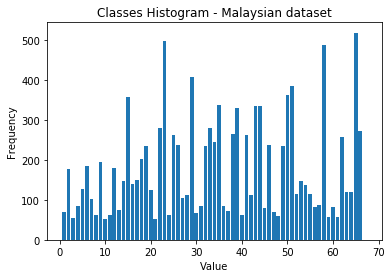

freq->
 [ 70 178  54  85 127 186 103  61 194  51  61 179  75 147 359 140 149 203
 234 126  52 281 499  63 263 238 106 113 407  66  85 235 280 245 338  84
  72 264 330  63 263 113 336 336  79 238  70  59 234 362 385 115 147 137
 115  83  87 489  56  82  57 257 121 121 519 273]
Mean: 181.82
 Var: 14634.21
 Max: 519.00
 Min: 51.00
 Sum: 12000.00
 STD: 120.97
 CV: 0.67

Total number of objects: 12000


In [437]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

file_p = 'results{}/gt_final.txt'.format(experiment)

#file_p = '/home/hossam/PycharmProjects/tsr-py-faster-rcnn/data/GTSDB/Annotations/gt.txt'

file = open(file_p,'rt')


tmp = []
for line in file:
    tmp.append( int(line.split(';')[5].replace('\r\n',''))+1)
#plt.hist(x, normed=True, bins=30)
# hist, bins = np.histogram(tmp, bins=66)
# width = 0.7 * (bins[1] - bins[0])
# center = (bins[:-1] + bins[1:]) / 2
# plt.bar(center, hist, align='center', width=width)
# plt.legend()
# plt.show()

plt.hist(tmp,histtype='bar', rwidth=0.8,bins=range(1,num_cls+3,1), align='left')
###plt.hist(tmp,histtype='bar', rwidth=0.8,bins=range(1,50,1), align='left')
plt.title("Classes Histogram - Malaysian dataset")
plt.xlabel("Value")
plt.ylabel("Frequency")

plt.show()

#print tmp
file.close()
a = np.array(tmp)
unique, counts = np.unique(a, return_counts=True)

frq = np.array(counts)
print ('freq->\n',counts)
#print keep
#print classes[keep]
#print a.mean(), a.var(), a.max(), a.min(), a.sum(), a.std()
print ('Mean: {:.2f}\n'.format(frq.mean()),\
    'Var: {:.2f}\n'.format(frq.var()),\
    'Max: {:.2f}\n'.format(frq.max()),\
    'Min: {:.2f}\n'.format(frq.min()),\
    'Sum: {:.2f}\n'.format(frq.sum()),\
    'STD: {:.2f}\n'.format(frq.std()),\
    'CV: {:.2f}\n'.format(frq.std()/frq.mean()))
print ('Total number of objects:',len(tmp))

# End of Elimination

# For Testing

In [111]:
#x = cv2.imread('/home/mjiit/Hossam/mtsd_augmentation/data/testing/short/1_aug.jpg')

#os.remove('/home/mjiit/Hossam/mtsd_augmentation/data/testing/short/1_aug.jpg')

#cv2.imwrite('/home/mjiit/Hossam/mtsd_augmentation/data/testing/short/1_aug.jpg', x)

dicte = {'1':[(5,6), (7,8)], '7':[(9,9)], '9':[(0,0)]}
print dicte

del_dicte = []

for did in dicte:
    if did == '7':
        del_dicte.append(did)

for kk in del_dicte:
    del dicte[kk]
print dicte

test = [(1,2), (3,4), (5,7)]

print '__', dicte
dicte['9'] = test
test = [(1,3),(9,0)]
print '---', dicte

{'1': [(5, 6), (7, 8)], '9': [(0, 0)], '7': [(9, 9)]}
{'1': [(5, 6), (7, 8)], '9': [(0, 0)]}
__ {'1': [(5, 6), (7, 8)], '9': [(0, 0)]}
--- {'1': [(5, 6), (7, 8)], '9': [(1, 2), (3, 4), (5, 7)]}


In [438]:
len(my_dict)

9076

In [58]:
my_dict.items()[2]

('aug2_original_P1840287_aug.jpg_3e368841-d808-4b58-afc5-37ff6baac7d9.jpg',
 [(2756, 1112, 2965, 1309, 64)])

In [59]:
print my_dict.items()[3]

('aug2_original_P1840387_aug.jpg_e0744d93-8e90-4234-8e61-4f5d6c9b1cbf.jpg', [(1055, 1248, 1412, 1569, 22)])


In [385]:
print classes[16]

height-limit-sign-6.-m


In [148]:
# mask with different colors space per each object sequential

#./data/test/gt/P1840014.JPG
#./data/test/gt/P1840114.JPG
# P1860079.JPG

#ff = '130.jpg'
ff = 'P1840185.JPG'
im = cv2.imread(os.path.join(mask_path,ff))
f = open(os.path.join(label_path, ff.split('.')[0]+'.txt'), 'r')
#im[im == 255] = 1
#im[im == 0] = 255
#im[im == 1] = 0
lines = f.readlines()
print 'Number of objects', len(lines)
for i in range(0, len(lines)):
    lower = np.array(color_list[i])-10
    upper = np.array(color_list[i])+10
    mask = cv2.inRange(im, lower, upper)
    im3 = cv2.bitwise_and(im, im, mask=mask)


    print 'obj#', i
    im2 = cv2.cvtColor(im3, cv2.COLOR_BGR2GRAY)

    print np.max(im2), np.min(im2)

    cv2.imwrite('test'+str(i)+'.jpg', im2)
    ret, thresh = cv2.threshold(im2, 0, np.max(im2)+1 ,cv2.THRESH_BINARY)
    _, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    print len(contours)
    #for i in range(0, len(contours)):
        #if(i%2 == 0)
    
    # getting the maximum width contours
    x,y,w,h = cv2.boundingRect(contours[0])
    for cnt in contours:
        cx, cy, cw, ch = cv2.boundingRect(cnt)
        if cw > w:
            x,y,w,h = cx, cy, cw, ch
    #cnt = contours[i]
    
    cv2.rectangle(im, (x,y), (x+w, y+h), (0,240,180), 5)
    print (x,y), (x+w, y+h)
    cv2.imwrite(str(i)+'.jpg', im)
    
    print '_______'

Number of objects 7
obj# 0
32 0
1
(240, 1832) (786, 2371)
_______
obj# 1
179 0
4
(255, 1207) (791, 1744)
_______
obj# 2
106 0
9
(640, 89) (814, 260)
_______
obj# 3
255 0
5
(1776, 1737) (1851, 1812)
_______
obj# 4
79 0
16
(2840, 1731) (2877, 1768)
_______
obj# 5
150 0
6
(1831, 1743) (1896, 1829)
_______
obj# 6
17 0
13
(1811, 1609) (1896, 1689)
_______


In [40]:
im = cv2.imread('./data/test/images/P1840121.JPG')
f = open('./data/labels/P1840121.txt')
lines = f.readlines()

im_out = np.zeros(im.shape, np.uint8)

for line in lines:
    spl = line.split(' ')
    x1 = int(spl[1])+1
    y1 = int(spl[2])+1
    x2 = int(spl[3])-1
    y2 = int(spl[4])-1
    
    cv2.rectangle(im_out, (x1,y1), (x2,y2),(255,255,255), -1)
    
cv2.imwrite('test.jpg', im_out)   

True

In [123]:
im = cv2.imread('./data/test/gt/P1840217.JPG')
im2 = cv2.cvtColor(im3, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(im2, 8, 8 ,8)
_, contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
for i in range(0, len(contours)):
    x,y,w,h = cv2.boundingRect(contours[i])
    cv2.rectangle(im, (x,y), (x+w, y+h), (0,255,0), 2)
    print (x,y), (x+w, y+h)
    cv2.imwrite(str(i)+'.jpg', im)

(2644, 1198) (2805, 1366)
(2800, 1360) (2804, 1365)
(2654, 1360) (2801, 1365)
(2650, 1360) (2654, 1364)
(2645, 1360) (2649, 1365)
(2650, 1199) (2653, 1361)
(2646, 1199) (2649, 1361)


946 / 977


Button(description=u'Next', style=ButtonStyle())

Button(description=u'Back', style=ButtonStyle())

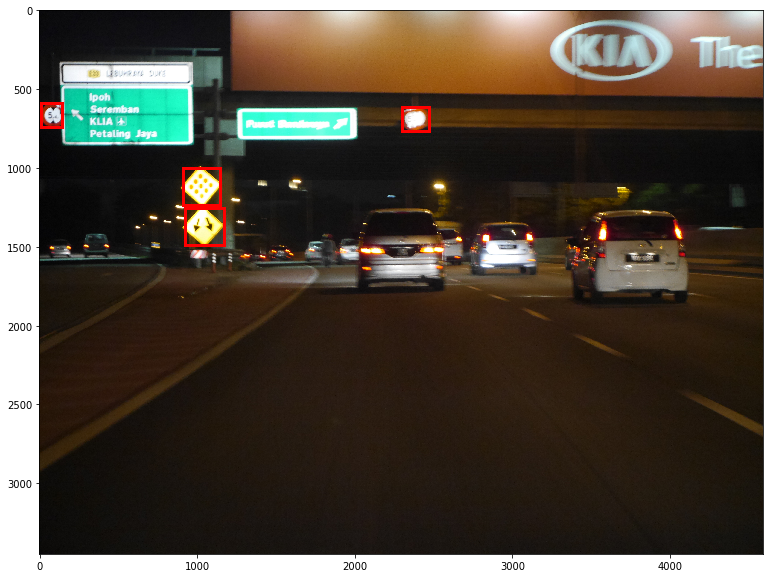

In [286]:
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
import matplotlib.image as mpimg

%matplotlib inline
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual#, Button
import ipywidgets as widgets
from IPython import display

import matplotlib.patches as patches


i=0
button_next = widgets.Button(description="Next")
button_back = widgets.Button(description="Back")

im_path = './data/MTSD/Images/'
gt_in_p = './data/MTSD/Annotations/gt.txt'
gt_in_f = open(gt_in_p, 'r')

lines = gt_in_f.readlines()
dic = {}

for line in lines:
    spl = line.split(';')
    if dic.has_key(spl[0]):
        dic[spl[0]].append(line)
    else:
        dic[spl[0]] = [line]

print(i+1,'/',len(dic))
display.display(button_next,button_back)
#display.display(button_no)
fig,ax = plt.subplots(1, figsize = (20,10))
#plt.figure(figsize=(200,100))
ax.imshow( Image.open( os.path.join(im_path,dic.items()[i][0]) ) )
for k in dic.items()[i][1]:
    sp = k.split(';')
    rect = patches.Rectangle((int(sp[1]),int(sp[2])),int(sp[3])-int(sp[1]),int(sp[4])-int(sp[2]),linewidth=3,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

plt.show()

def on_click_next(b):
    #print("yes")
    global i
    
    i=i+1
    found = False
    while (not found) and (i<len(dic)):
        for k in dic.items()[i][1]:
            if k.split(';')[5] == '62\n':
                found = True

        i = i+1
    i=i-1
    display.clear_output()
    print(dic.items()[i])
    if i>= len(dic):
        print("Finish")
        return
    
    print(i,'/',len(dic))
    display.display(button_next)
    display.display(button_back)
    fig,ax = plt.subplots(1, figsize = (20,10))
    ax.imshow( Image.open( os.path.join(im_path,dic.items()[i][0]) ) )
    im = cv2.imread(os.path.join(im_path, dic.items()[i][0]))
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    for k in dic.items()[i][1]:
        sp = k.split(';')
        x1 = int(sp[1])
        y1 = int(sp[2])
        x2 = int(sp[3])
        y2 = int(sp[4])
        rect = patches.Rectangle((int(sp[1]),int(sp[2])),int(sp[3])-int(sp[1]),int(sp[4])-int(sp[2]),linewidth=3,edgecolor='r',facecolor='none')
        fm = variance_of_laplacian(gray[y1:y2+1,x1:x2+1])
        print('blur factor = ',fm, (fm/float((y2-y1)*(x2-x1))))
        ax.add_patch(rect)
    plt.show()
    
def on_click_back(b):
    global i
    
    if i==0:
        return
              
    i=i-1
    
    display.clear_output()
    
    
    print(i+1,'/',len(dic))
    display.display(button_next)
    display.display(button_back)
    fig,ax = plt.subplots(1, figsize = (20,10))
    ax.imshow( Image.open( os.path.join(im_path,dic.items()[i][0]) ) )
    for k in dic.items()[i][1]:
        sp = k.split(';')
        rect = patches.Rectangle((int(sp[1]),int(sp[2])),int(sp[3])-int(sp[1]),int(sp[4])-int(sp[2]),linewidth=3,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    plt.show()

    
button_next.on_click(on_click_next)
button_back.on_click(on_click_back)

128 / 977


Button(description=u'Next', style=ButtonStyle())

Button(description=u'Back', style=ButtonStyle())

P1860101.JPG
w= 319 h= 316
w= 171 h= 169
w= 111 h= 109
w= 53 h= 79
w= 33 h= 31
w= 48 h= 49


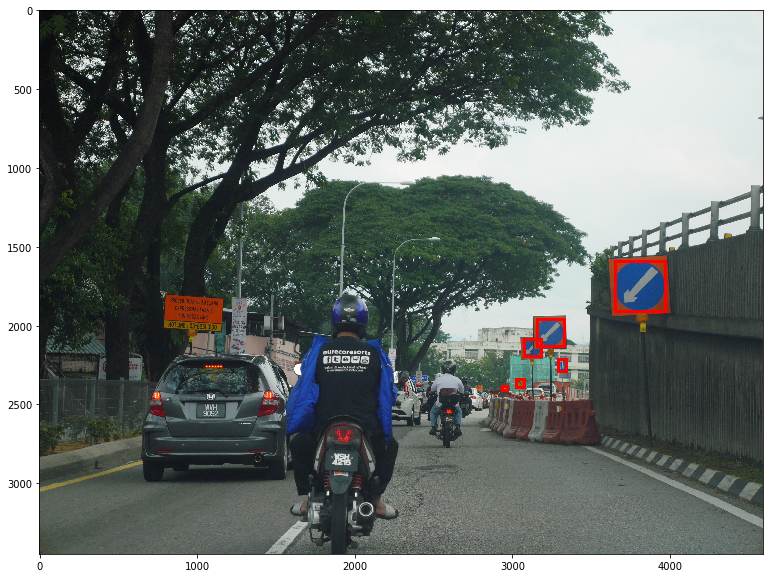

In [296]:
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
import matplotlib.image as mpimg

%matplotlib inline
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual#, Button
import ipywidgets as widgets
from IPython import display

import matplotlib.patches as patches


i=0
button_next = widgets.Button(description="Next")
button_back = widgets.Button(description="Back")

im_path = './data/MTSD/Images/'
gt_in_p = './data/MTSD/Annotations/gt.txt'
gt_in_f = open(gt_in_p, 'r')

lines = gt_in_f.readlines()
dic = {}

for line in lines:
    spl = line.split(';')
    if dic.has_key(spl[0]):
        dic[spl[0]].append(line)
    else:
        dic[spl[0]] = [line]

print(i+1,'/',len(dic))
display.display(button_next,button_back)
#display.display(button_no)
fig,ax = plt.subplots(1, figsize = (20,10))
#plt.figure(figsize=(200,100))
myimg = Image.open( os.path.join(im_path,dic.items()[i][0]))
ax.imshow( myimg )
myflag = False
for k in dic.items()[i][1]:
    sp = k.split(';')
    rect = patches.Rectangle((int(sp[1]),int(sp[2])),int(sp[3])-int(sp[1]),int(sp[4])-int(sp[2]),linewidth=3,edgecolor='r',facecolor='none')
    print('w=', int(sp[3])-int(sp[1]), 'h=',int(sp[4])-int(sp[2]))
    ax.add_patch(rect)

plt.show()

def on_click_next(b):
    #print("yes")
    global i
    
    i=i+1
    found = False
    while (not found) and (i<len(dic)):
        for k in dic.items()[i][1]:
            if k.split(';')[5] == '62\n':
                found = True

        i = i+1
    i=i-1
    display.clear_output()
    print(dic.items()[i])
    if i>= len(dic):
        print("Finish")
        return
    
    print(i,'/',len(dic))
    display.display(button_next)
    display.display(button_back)
    fig,ax = plt.subplots(1, figsize = (20,10))
    ax.imshow( Image.open( os.path.join(im_path,dic.items()[i][0]) ) )
    im = cv2.imread(os.path.join(im_path, dic.items()[i][0]))
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    for k in dic.items()[i][1]:
        sp = k.split(';')
        x1 = int(sp[1])
        y1 = int(sp[2])
        x2 = int(sp[3])
        y2 = int(sp[4])
        rect = patches.Rectangle((int(sp[1]),int(sp[2])),int(sp[3])-int(sp[1]),int(sp[4])-int(sp[2]),linewidth=3,edgecolor='r',facecolor='none')
        fm = variance_of_laplacian(gray[y1:y2+1,x1:x2+1])
        print('blur factor = ',fm, (fm/float((y2-y1)*(x2-x1))))
        print('w=', int(sp[3])-int(sp[1]), 'h=',int(sp[4])-int(sp[2]))
        ax.add_patch(rect)
    plt.show()
    
def on_click_back(b):
    global i
    
    if i==0:
        return
              
    i=i-1
    
    display.clear_output()
    
    
    print(i+1,'/',len(dic))
    display.display(button_next)
    display.display(button_back)
    fig,ax = plt.subplots(1, figsize = (20,10))
    ax.imshow( Image.open( os.path.join(im_path,dic.items()[i][0]) ) )
    print(dic.items()[i][1][0].split(';')[0])
    for k in dic.items()[i][1]:
        sp = k.split(';')
        rect = patches.Rectangle((int(sp[1]),int(sp[2])),int(sp[3])-int(sp[1]),int(sp[4])-int(sp[2]),linewidth=3,edgecolor='r',facecolor='none')
        print('w=', int(sp[3])-int(sp[1]), 'h=',int(sp[4])-int(sp[2]))
        
        ax.add_patch(rect)
    plt.show()

    
button_next.on_click(on_click_next)
button_back.on_click(on_click_back)